In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm
import torch

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

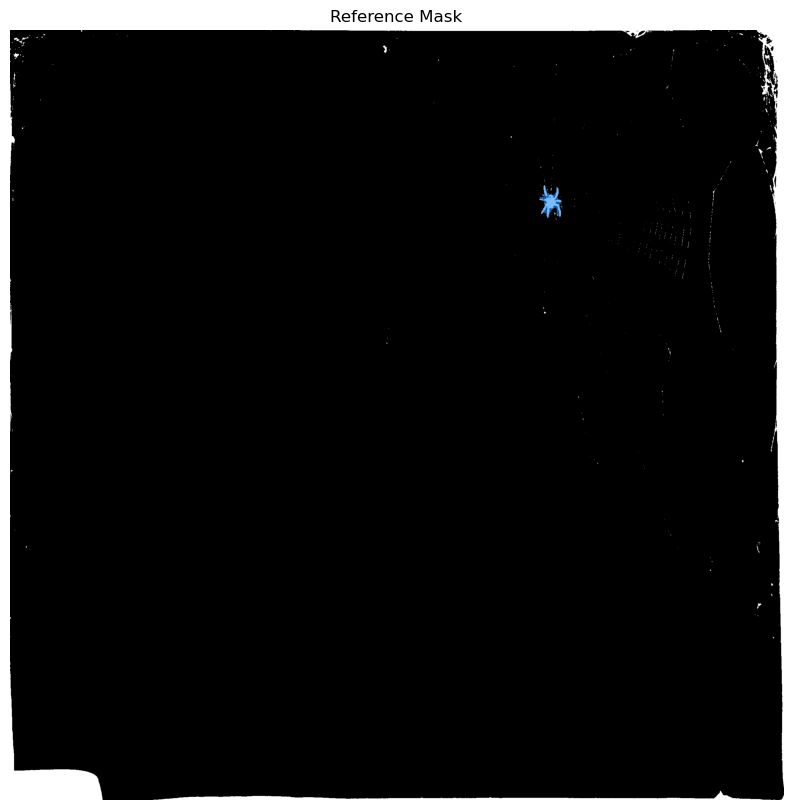

In [8]:
#import in the reference image and mask from the original Targeting Spider notebook
rgb_thresh = cv2.imread(r"C:\Users\adamain\Downloads\Reference_Spider_Images\Reference_Image.png")
reference = cv2.imread(r"C:\Users\adamain\Downloads\Reference_Spider_Images\Reference_Mask.png")
reference = cv2.cvtColor(reference, cv2.COLOR_RGB2GRAY)
_, reference = cv2.threshold(reference, 127, 1, cv2.THRESH_BINARY)


plt.figure(figsize=(10,10))
plt.imshow(rgb_thresh)
show_mask(reference, plt.gca())
plt.title(f"Reference Mask")
plt.axis('off')
plt.show()  

In [9]:
#Load in the SAM2 Predictor
import torch
from segment_anything import sam_model_registry, SamPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = r"C:\Users\adamain\Downloads\sam2.1_hiera_base_plus.pt"

# Load the checkpoint dict manually
checkpoint = torch.load(checkpoint_path, map_location=device)

# Extract the actual model weights dict
state_dict = checkpoint.get("model", checkpoint)  # fallback if "model" key not present

# Create model without checkpoint argument
sam2_model = sam_model_registry["vit_h"]()

# Load state dict manually, strict=False to avoid errors on unexpected keys
sam2_model.load_state_dict(state_dict, strict=False)

sam2_model.to(device)
sam2_model.eval()

sam2_predictor = SamPredictor(sam2_model)

In [5]:
#Load in the Grounding Dino model and processor
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
model_id = "IDEA-Research/grounding-dino-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino_processor = AutoProcessor.from_pretrained(model_id)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

c:\Users\adamain\.conda\envs\imgid\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\adamain\.conda\envs\imgid\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [19]:
def process_image(image, aggressive_thresholding = True):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if aggressive_thresholding:
        _, thresh = cv2.threshold(image,180, 255, cv2.THRESH_BINARY)
    else:
        _, thresh = cv2.threshold(image,140, 255, cv2.THRESH_BINARY)
    rgb_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    return rgb_thresh

In [11]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import cv2
from scipy.ndimage import center_of_mass

def find_spider_with_dino_and_sam(
    full_image: np.ndarray,
    reference_mask: np.ndarray,
    dino_model,
    dino_processor,
    sam_predictor,
    box_threshold: float = 0.4,
    text_threshold: float = 0.3,
    sam_iou_threshold: float = 0.5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) DINO inference
    pil = Image.fromarray(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
    inputs = dino_processor(images=pil, text=[["spider"]], return_tensors="pt").to(device)
    with torch.no_grad():
        out = dino_model(**inputs)
    res = dino_processor.post_process_grounded_object_detection(
        out, inputs.input_ids,
        box_threshold=box_threshold,
        text_threshold=text_threshold,
        target_sizes=[pil.size[::-1]]
    )[0]

    # 2) Decide crop region
    if len(res["boxes"]) > 0:
        # take highest‐score box
        scores = res["scores"].cpu().numpy()
        boxes = res["boxes"].cpu().numpy().astype(int)
        idx = np.argmax(scores)
        x0, y0, x1, y1 = boxes[idx]
        crop_img = full_image[y0:y1, x0:x1]
        crop_origin = (x0, y0)
        box = (x0, y0, x1, y1)
    else:
        # fallback: full image
        crop_img = full_image
        crop_origin = (0, 0)
        box = None

    # 3) Compute center‐of‐mass point from reference mask
    # (convert reference mask coords into the crop’s coordinate frame)
    ys, xs = np.where(reference_mask > 0)
    if len(ys) == 0:
        raise ValueError("Reference mask empty; cannot prompt SAM.")
    com_y, com_x = center_of_mass(reference_mask)
    # shift to crop frame
    com_x_crop = com_x - crop_origin[0]
    com_y_crop = com_y - crop_origin[1]
    point = np.array([[com_x_crop, com_y_crop]])
    label = np.array([1])  # foreground

    # 4) SAM inference on crop using point prompt
    sam_predictor.set_image(crop_img)
    masks, scores, _ = sam_predictor.predict(
        point_coords=point,
        point_labels=label,
        multimask_output=False
    )
    sam_mask_crop = masks[0]

    # 5) (Optional) check IoU between DINO box and SAM mask bbox if box exists
    if box is not None:
        # compute SAM mask bbox
        ys2, xs2 = np.where(sam_mask_crop)
        ymin2, xmin2 = ys2.min(), xs2.min()
        ymax2, xmax2 = ys2.max(), xs2.max()
        # convert to full‐image coords
        sam_box = np.array([xmin2, ymin2, xmax2, ymax2]) + np.array(crop_origin*2)
        # IoU test
        def _iou(a, b):
            xA, yA = max(a[0], b[0]), max(a[1], b[1])
            xB, yB = min(a[2], b[2]), min(a[3], b[3])
            inter = max(0, xB-xA)*max(0, yB-yA)
            area = (a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter
            return inter/area if area>0 else 0
        dino_box = np.array(box)
        if _iou(dino_box, sam_box) < sam_iou_threshold:
            # if low agreement, you could fallback to DINO box mask or union; here we stick with SAM
            pass

    # 6) Build full‐image mask from crop mask
    full_mask = np.zeros(full_image.shape[:2], dtype=np.uint8)
    x0, y0 = crop_origin
    h, w = sam_mask_crop.shape
    full_mask[y0:y0+h, x0:x0+w] = (sam_mask_crop>0).astype(np.uint8)

    return full_mask, box

In [12]:
def crop_to_mask_circle(image, mask, padding=10):
    """
    Crop the image to the smallest enclosing circle around the non-zero region in the mask.

    Parameters:
        image (np.ndarray): Original image (H, W, C)
        mask (np.ndarray): Binary mask (H, W) where non-zero values define the region of interest
        padding (int): Optional padding around the circle (in pixels)

    Returns:
        cropped_image (np.ndarray): Cropped image around the circular region
    """
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Get coordinates of the non-zero mask area
    points = cv2.findNonZero(mask)
    if points is None:
        return None  # or raise an exception

    # Find the smallest enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(points)

    # Add padding
    x, y, radius = int(x), int(y), int(radius + padding)

    # Compute square bounding box
    x1 = max(x - radius, 0)
    y1 = max(y - radius, 0)
    x2 = min(x + radius, image.shape[1])
    y2 = min(y + radius, image.shape[0])

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]
    cropped_mask = mask[y1:y2, x1:x2]

    return cropped_image, cropped_mask


In [13]:
def process_spider(crop, aggressive_closing = False):
    if len(crop.shape) == 3:
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    if aggressive_closing:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
    else: 
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
    closed = cv2.morphologyEx(crop, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    edited = np.zeros_like(closed)  # blank image to draw on

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        aspect_ratio = float(w) / h if h != 0 else 0

        if area > 500 and aspect_ratio < 4:
            cv2.drawContours(edited, [cnt], -1, 255, thickness=cv2.FILLED)   

    edited = cv2.GaussianBlur(edited, (3, 3), 0)
    _, edited = cv2.threshold(edited, 127, 255, cv2.THRESH_BINARY) 
    return edited

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN

def count_spider_legs(image, show_image=False, exclude_centerband_px=2, preprocess=True, output_dir = None, base_name = None):
    if preprocess:
        # More aggressive preprocessing to extend short legs
        # First, dilate to thicken legs
        kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        dilated = cv2.dilate(image, kernel1, iterations=2)
        
        # Then use opening to separate merged parts
        kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        opened = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel2)
        
        # Final dilation to extend leg tips
        kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
        enhanced = cv2.dilate(opened, kernel3, iterations=1)
    else:
        enhanced = image.copy()
    
    # Find contours and select the largest one (spider body + legs)
    contours, _ = cv2.findContours(enhanced, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0

    main_contour = max(contours, key=cv2.contourArea)

    # Get centroid of the contour
    M = cv2.moments(main_contour)
    if M["m00"] == 0:
        return 0
    cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
    center = np.array([cx, cy])

    # Convert contour to polar coordinates with shifted angle reference
    # Shift by 90° so ±180° is on vertical axis instead of horizontal
    angles = []
    radii = []
    points = []

    for pt in main_contour:
        x, y = pt[0]
        vec = np.array([x, y]) - center
        angle = np.arctan2(vec[1], vec[0]) - np.pi/2  # Shift by 90°
        # Normalize to [-π, π] range
        if angle < -np.pi:
            angle += 2*np.pi
        elif angle > np.pi:
            angle -= 2*np.pi
        radius = np.linalg.norm(vec)
        angles.append(angle)
        radii.append(radius)
        points.append((x, y))

    angles = np.array(angles)
    radii = np.array(radii)
    points = np.array(points)

    # Sort points by angle
    sort_idx = np.argsort(angles)
    angles = angles[sort_idx]
    radii = radii[sort_idx]
    points = points[sort_idx]

    # Find radius peaks - much more sensitive for short legs
    peaks, properties = find_peaks(radii, distance=2, prominence=0.8, height=np.mean(radii))
    peak_angles = angles[peaks]
    peak_radii = radii[peaks]
    peak_points = points[peaks]

    # Show radius profile plot for debugging
    if show_image:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(np.degrees(angles), radii, 'b-', alpha=0.7)
        plt.plot(np.degrees(angles[peaks]), radii[peaks], 'ro', markersize=8)
        plt.xlabel('Angle (degrees)')
        plt.ylabel('Radius')
        plt.title(f'Radius Profile ({len(peaks)} peaks found)')
        plt.grid(True)
        
        # Show image with all initial peaks
        plt.subplot(1, 2, 2)
        result = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
        cv2.circle(result, (cx, cy), 5, (0, 255, 0), -1)  # Center dot
        for i, pt in enumerate(peak_points):
            cv2.circle(result, tuple(pt), 3, (255, 0, 0), -1)  # All peaks in blue
            cv2.putText(result, str(i), (pt[0]+5, pt[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        plt.imshow(result)
        plt.axis("off")
        plt.title(f"All {len(peaks)} initial peaks")
        plt.tight_layout()
        plt.show()

    # Exclude points near vertical centerline
    filtered_angles = []
    filtered_radii = []
    filtered_points = []
    
    for angle, radius, pt in zip(peak_angles, peak_radii, peak_points):
        distance_from_center_x = abs(pt[0] - cx)
        if distance_from_center_x > exclude_centerband_px:
            filtered_angles.append(angle)
            filtered_radii.append(radius)
            filtered_points.append(pt)

    if len(filtered_angles) == 0:
        return 0

    filtered_angles = np.array(filtered_angles)
    filtered_radii = np.array(filtered_radii)
    filtered_points = np.array(filtered_points)

    # Cluster by angle to merge very close peaks
    angles_norm = (filtered_angles + 2 * np.pi) % (2 * np.pi)
    angles_reshaped = angles_norm.reshape(-1, 1)

    clusterer = DBSCAN(eps=np.deg2rad(6), min_samples=1)
    labels = clusterer.fit_predict(angles_reshaped)

    cluster_centers = []
    cluster_radii = []
    cluster_points = []

    for label in np.unique(labels):
        idxs = np.where(labels == label)[0]
        best_idx = idxs[np.argmax(filtered_radii[idxs])]
        cluster_centers.append(filtered_angles[best_idx])
        cluster_radii.append(filtered_radii[best_idx])
        cluster_points.append(filtered_points[best_idx])

    cluster_centers = np.array(cluster_centers)
    cluster_radii = np.array(cluster_radii)
    cluster_points = np.array(cluster_points)

    # Sort clusters by descending radius
    idx_sort_radius = np.argsort(-cluster_radii)
    peak_angles_sorted = cluster_centers[idx_sort_radius]
    peak_radii_sorted = cluster_radii[idx_sort_radius]
    peak_points_sorted = cluster_points[idx_sort_radius]

    # Angular suppression
    def angular_suppression(peak_angles, peak_radii, peak_points, min_angle_rad):
        selected = []
        for angle_i, radius_i, point_i in zip(peak_angles, peak_radii, peak_points):
            conflict = False
            for angle_j, _, _ in selected:
                angle_diff = abs(angle_i - angle_j)
                angle_diff = min(angle_diff, 2*np.pi - angle_diff)
                if angle_diff < min_angle_rad:
                    conflict = True
                    break
            if not conflict:
                selected.append((angle_i, radius_i, point_i))
        return selected

    min_angle_deg = 20
    selected = angular_suppression(peak_angles_sorted, peak_radii_sorted, peak_points_sorted, np.deg2rad(min_angle_deg))
    
    while len(selected) > 7 and min_angle_deg < 60:
        min_angle_deg += 2
        selected = angular_suppression(peak_angles_sorted, peak_radii_sorted, peak_points_sorted, np.deg2rad(min_angle_deg))

    # Final visualization
    if show_image:
        plt.figure(figsize=(8, 6))
        result = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
        cv2.circle(result, (cx, cy), 5, (0, 255, 0), -1)  # Center dot
        for i, (_, _, pt) in enumerate(selected):
            cv2.circle(result, tuple(pt), 4, (0, 255, 255), -1)  # Final legs in yellow
            cv2.putText(result, str(i+1), (pt[0]+5, pt[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        plt.imshow(result)
        plt.axis("off")
        plt.title(f"Final result: {len(selected)} legs detected")
        plt.show()
    #Optional Save
    if ((output_dir != None) and (base_name != None) and show_image):
        name_without_ext = os.path.splitext(base_name)[0]
        im_path = os.path.join(output_dir, f"{name_without_ext}_legs.png")
        cv2.imwrite(im_path, result)
    return len(selected)

In [15]:
directory = r"C:\Users\adamain\Downloads\cropped_frames"
image_paths = []
for filename in os.listdir(directory):
    if filename.lower().endswith(".jpg"):
        image_paths.append(os.path.join(directory, filename))
#We already have the mask for this one, it's the reference image/mask        
image_paths.remove(r"C:\Users\adamain\Downloads\cropped_frames\cropped_EX.jpg")
print(image_paths)

['C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - 1.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - 2.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - 3.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - 1.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - 2.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - 3.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 1.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 2.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 3.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 4.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - 5.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - C.jpg', 'C:\\Users\\adamain\\Downloads\\c

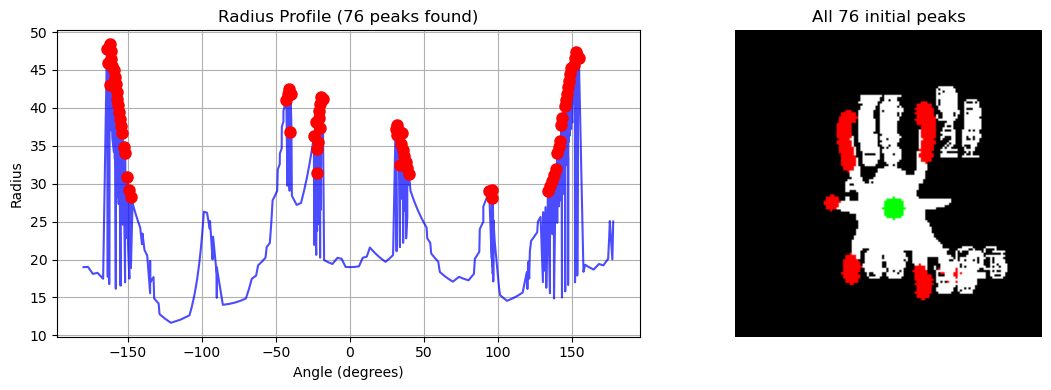

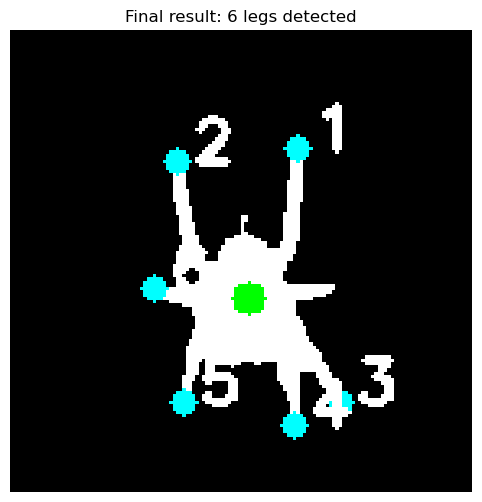

C:\Users\adamain\Downloads\cropped_frames\cropped_19 - 1.jpg


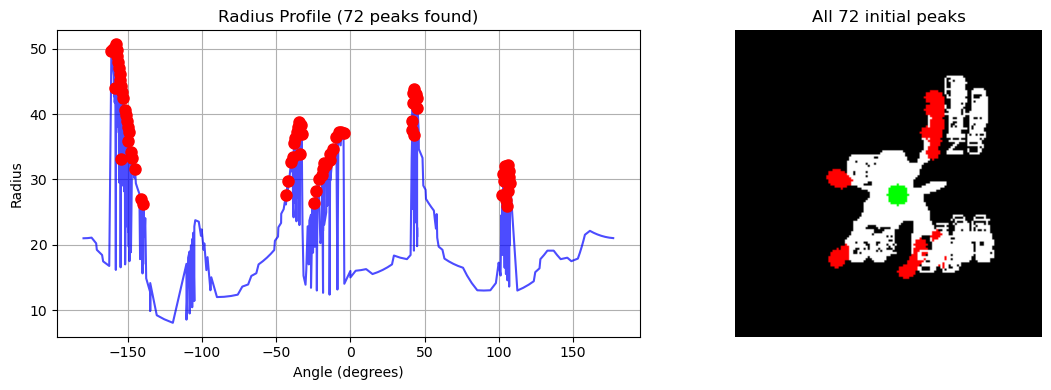

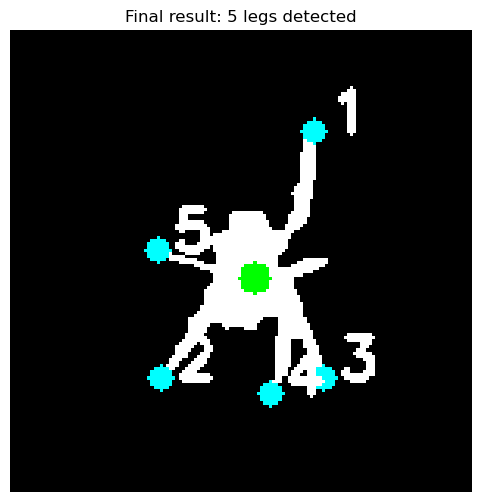

C:\Users\adamain\Downloads\cropped_frames\cropped_19 - 2.jpg


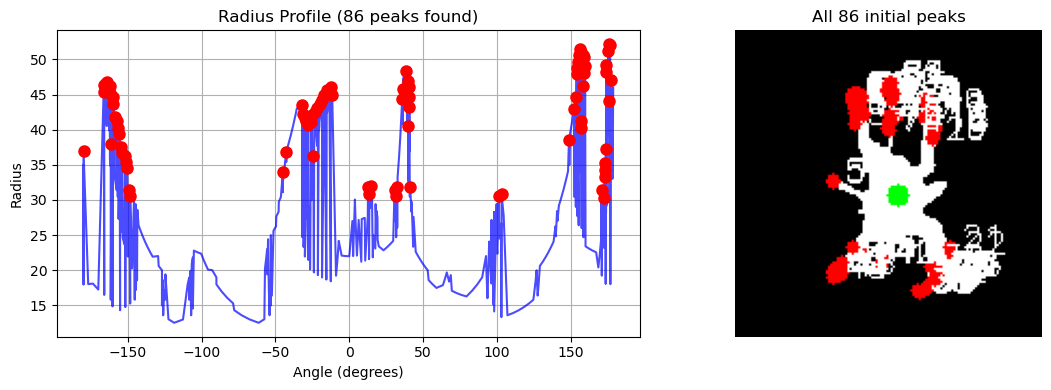

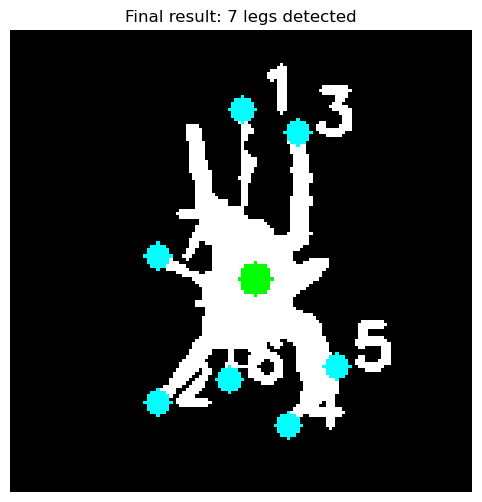

C:\Users\adamain\Downloads\cropped_frames\cropped_19 - 3.jpg


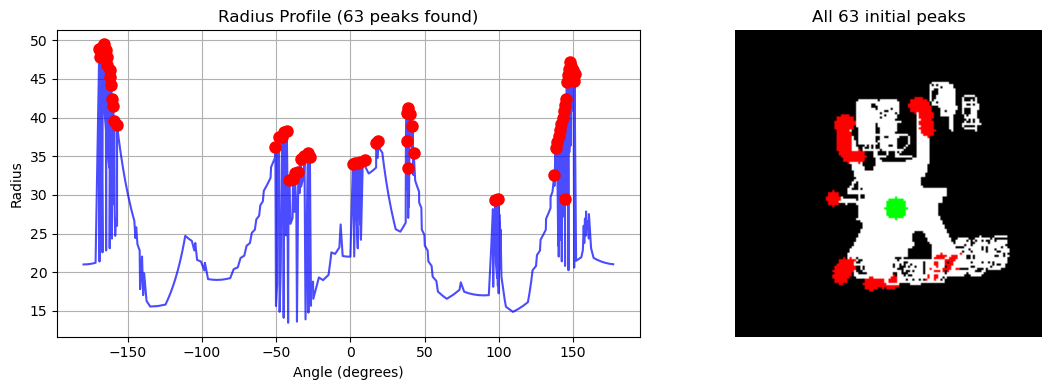

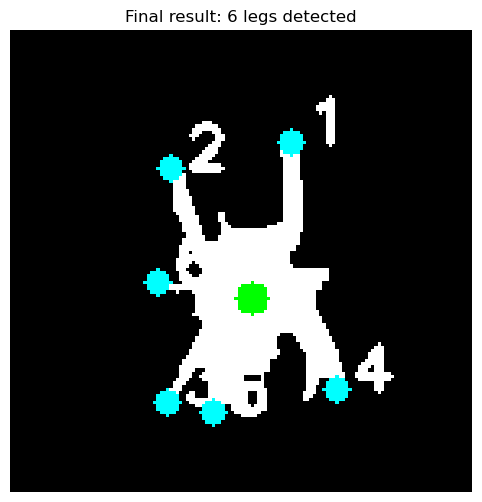

C:\Users\adamain\Downloads\cropped_frames\cropped_19 - C.jpg


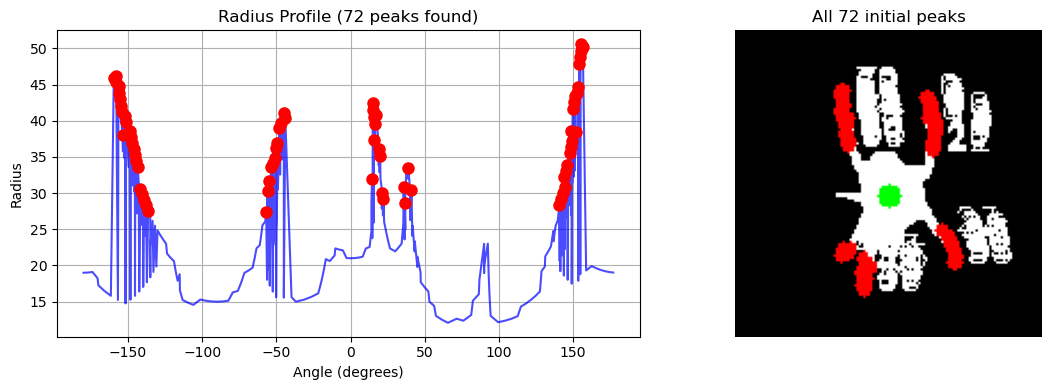

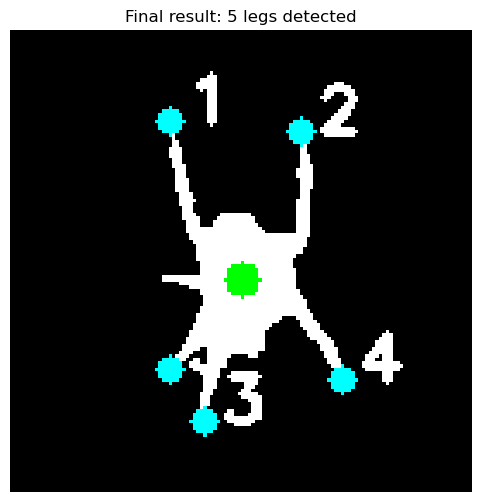

C:\Users\adamain\Downloads\cropped_frames\cropped_25 - 1.jpg


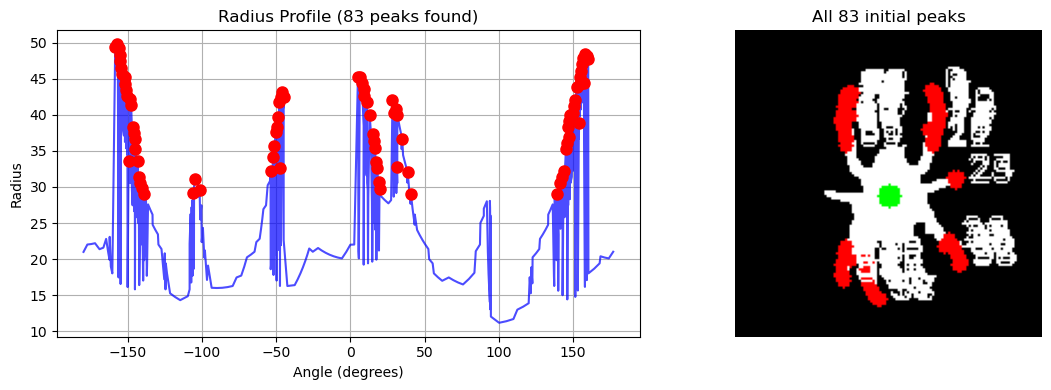

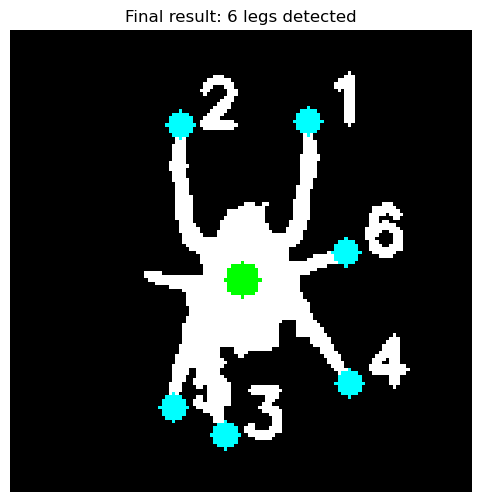

C:\Users\adamain\Downloads\cropped_frames\cropped_25 - 2.jpg


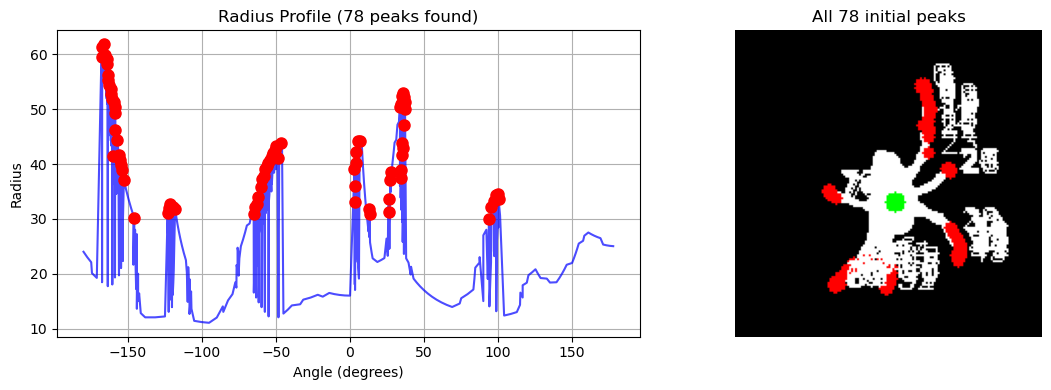

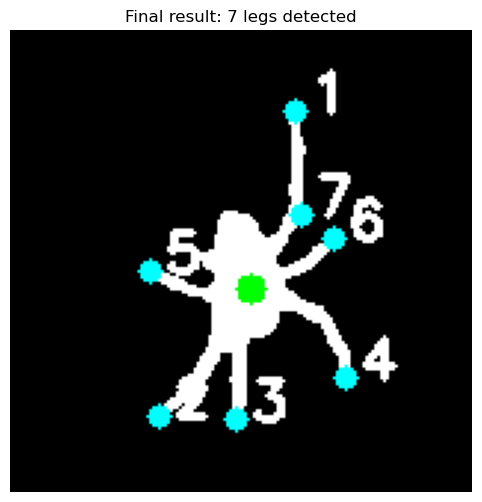

C:\Users\adamain\Downloads\cropped_frames\cropped_25 - 3.jpg


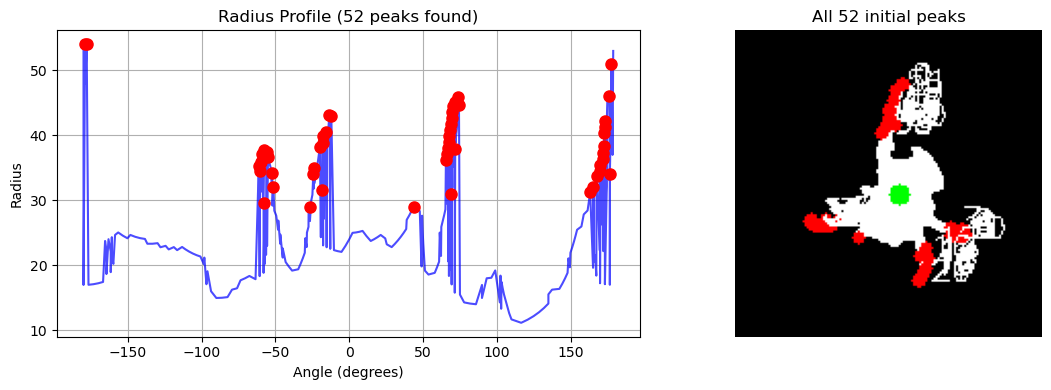

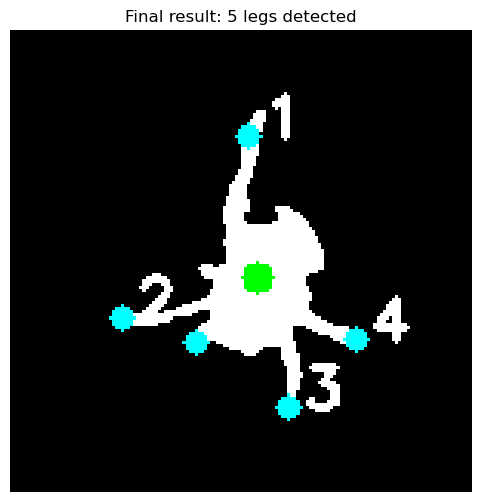

C:\Users\adamain\Downloads\cropped_frames\cropped_25 - C.jpg


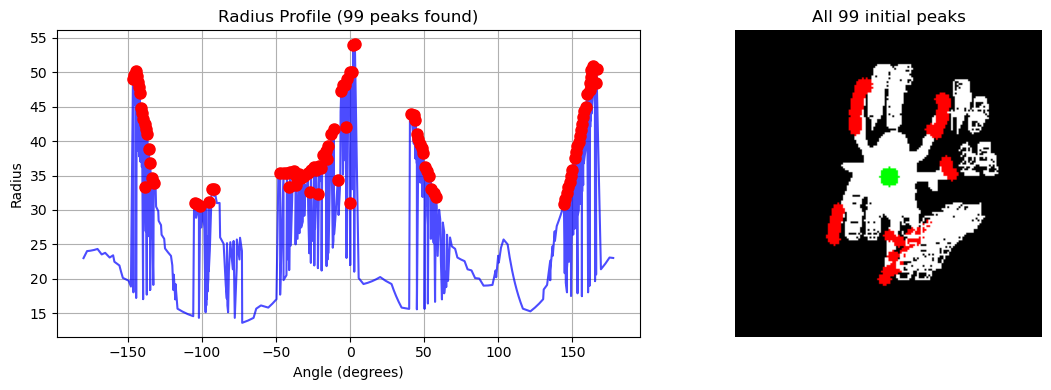

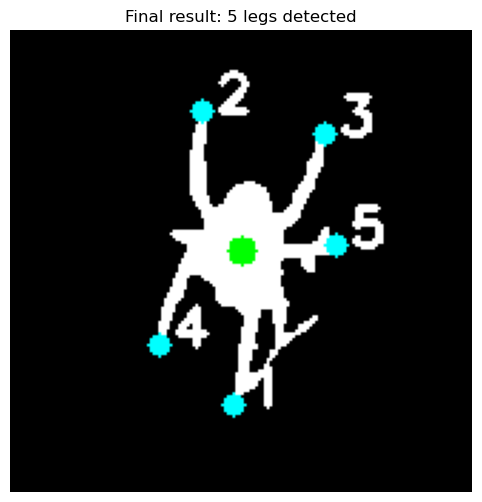

C:\Users\adamain\Downloads\cropped_frames\cropped_26 - 1.jpg


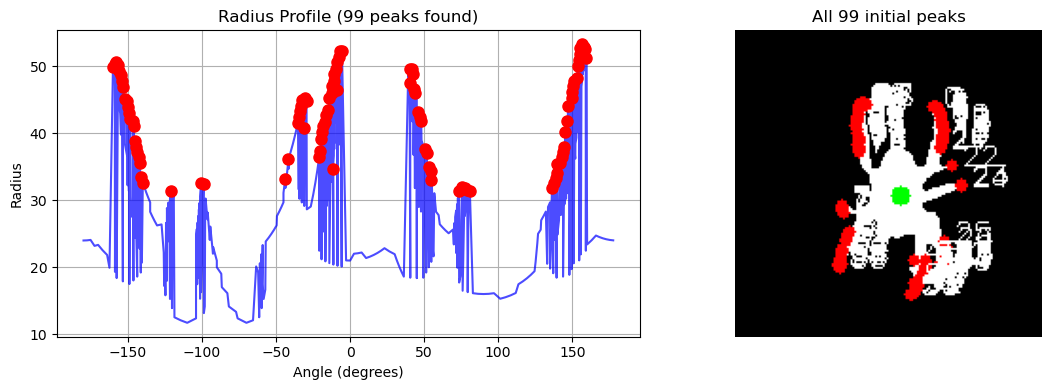

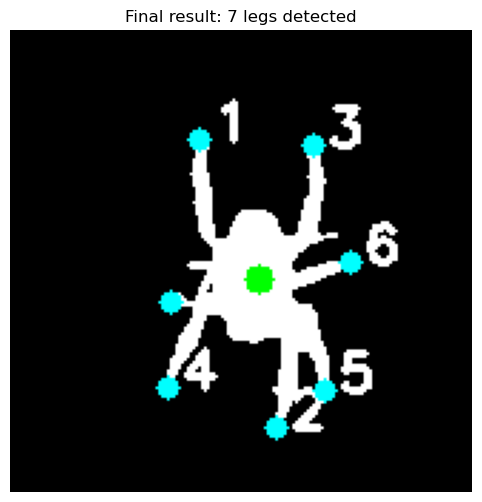

C:\Users\adamain\Downloads\cropped_frames\cropped_26 - 2.jpg


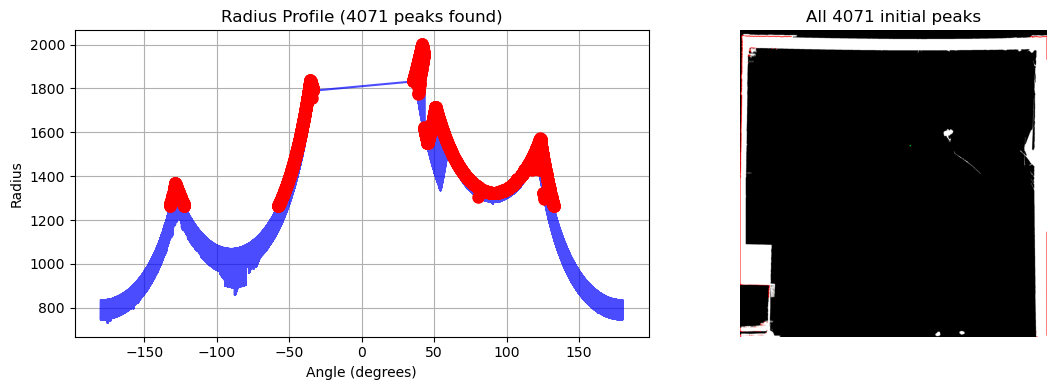

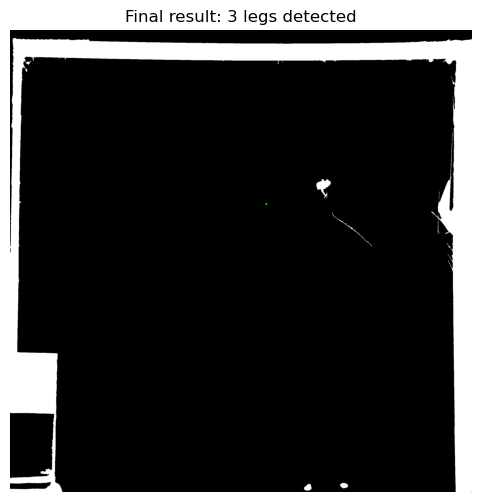

C:\Users\adamain\Downloads\cropped_frames\cropped_26 - 3.jpg


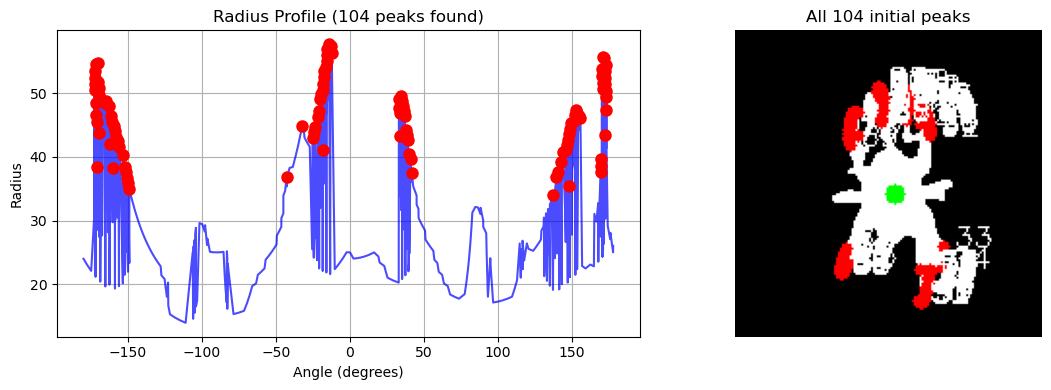

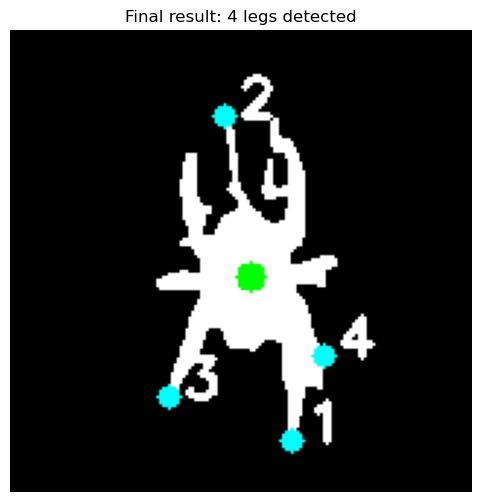

C:\Users\adamain\Downloads\cropped_frames\cropped_26 - 4.jpg


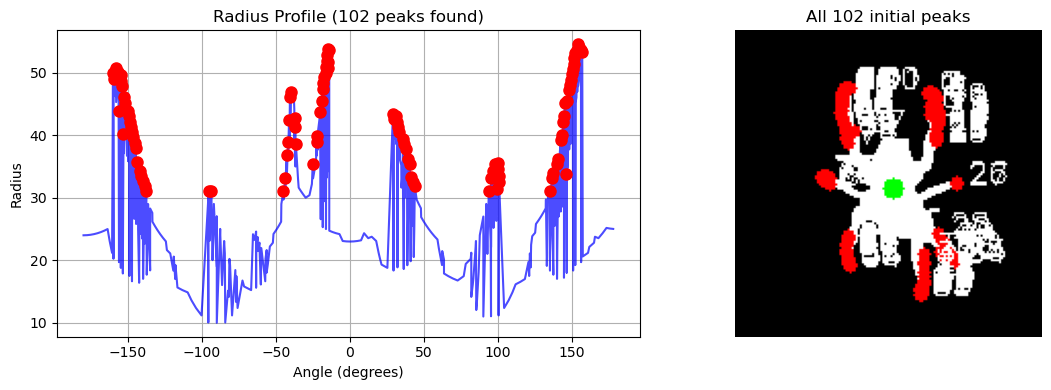

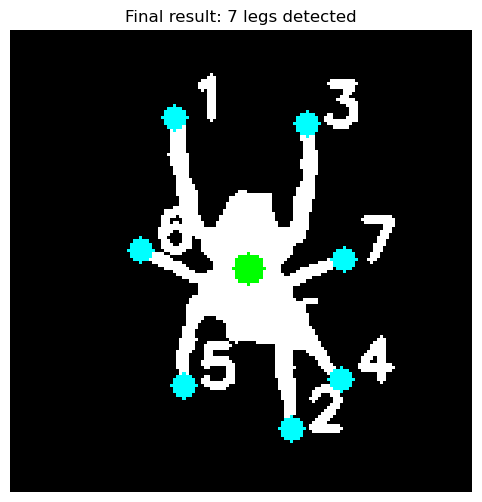

C:\Users\adamain\Downloads\cropped_frames\cropped_26 - 5.jpg


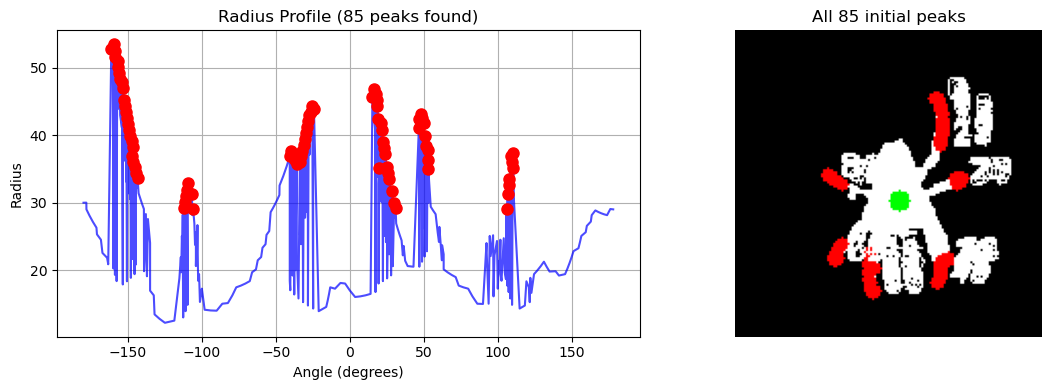

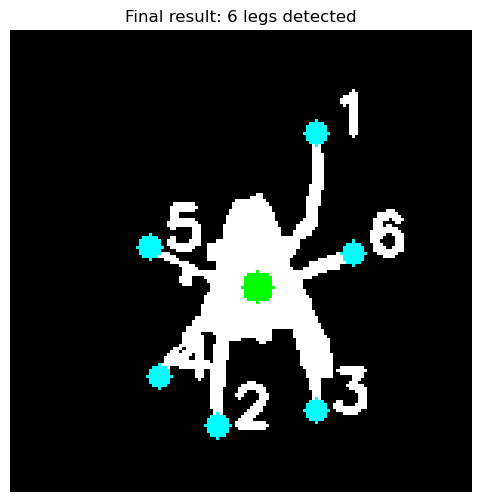

C:\Users\adamain\Downloads\cropped_frames\cropped_26 - C.jpg


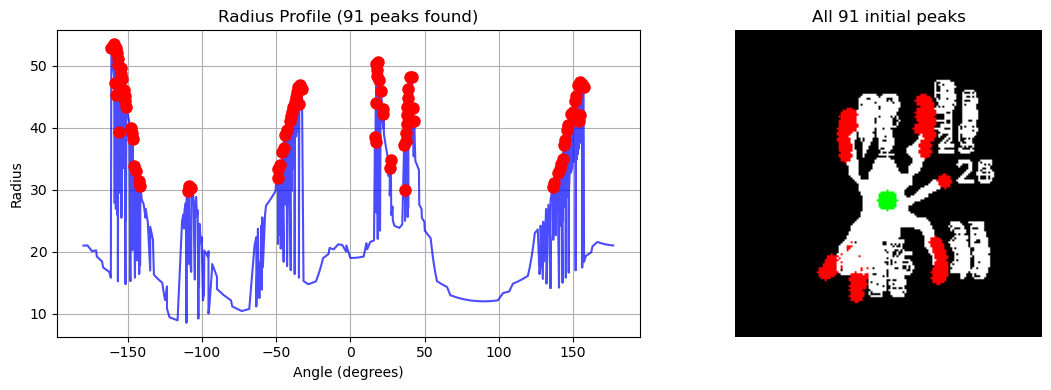

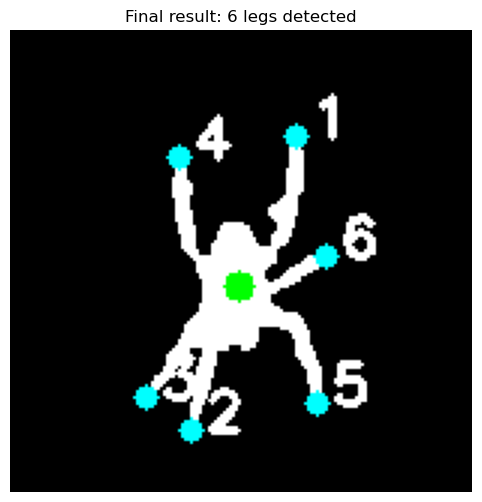

C:\Users\adamain\Downloads\cropped_frames\cropped_29 - 1.jpg


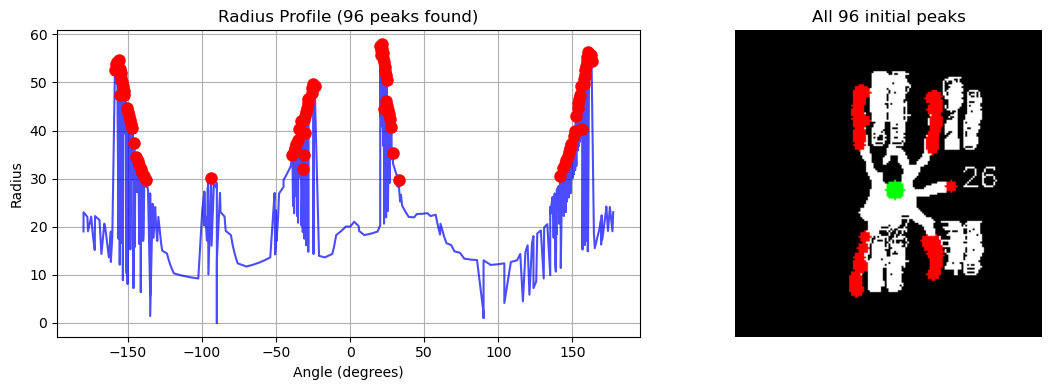

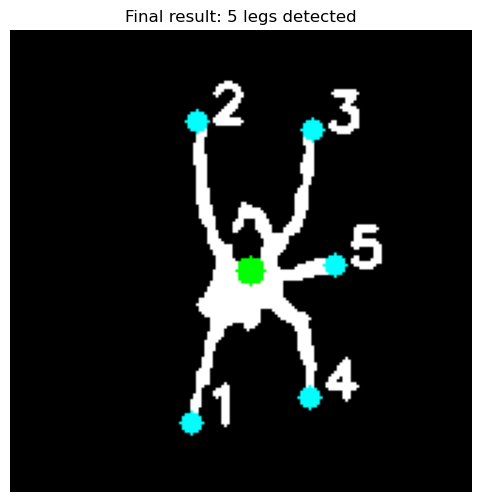

C:\Users\adamain\Downloads\cropped_frames\cropped_29 - 2.jpg


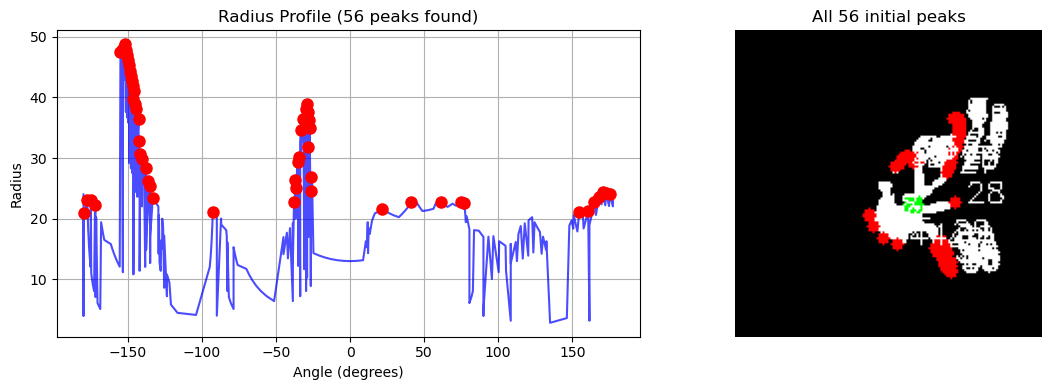

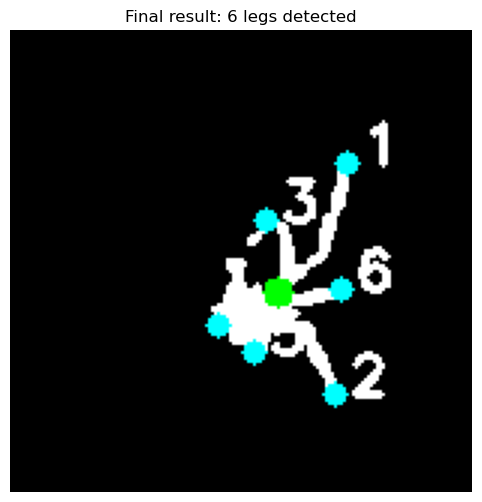

C:\Users\adamain\Downloads\cropped_frames\cropped_29 - 3.jpg


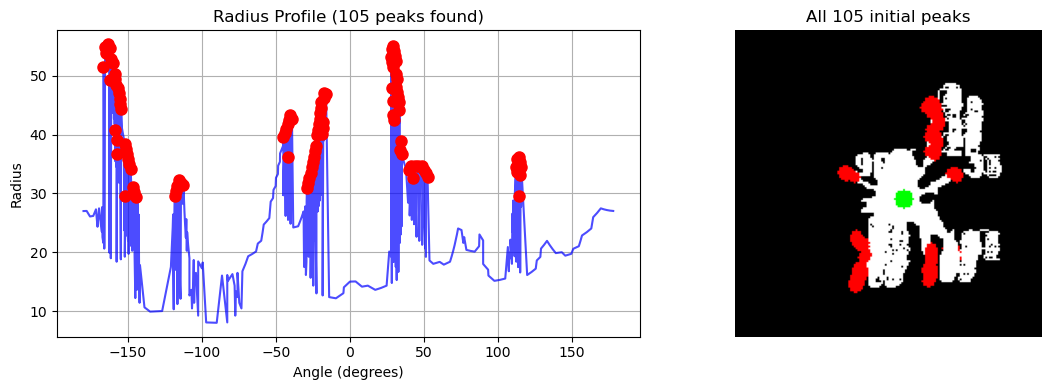

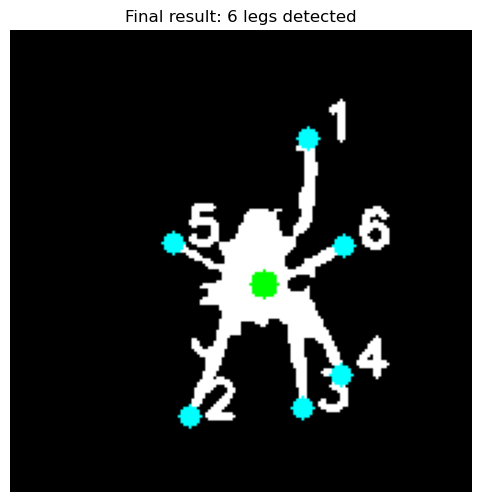

C:\Users\adamain\Downloads\cropped_frames\cropped_29 - C.jpg


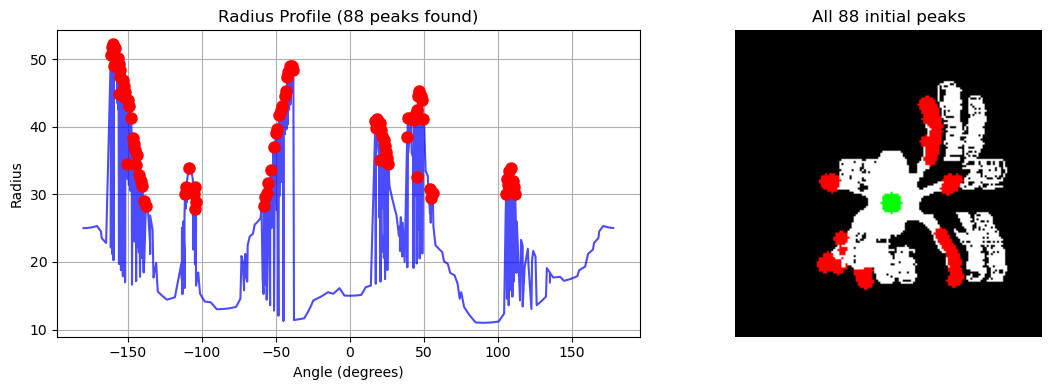

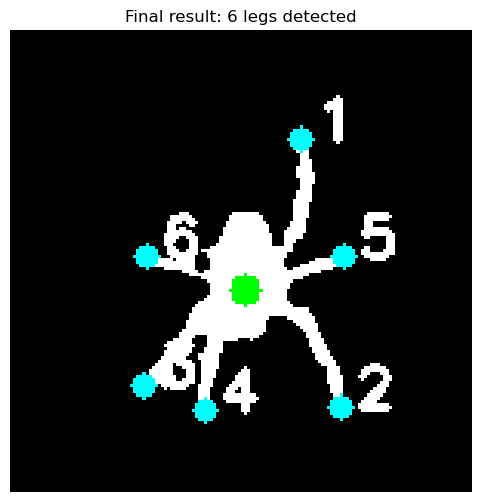

C:\Users\adamain\Downloads\cropped_frames\cropped_32 - 1.jpg


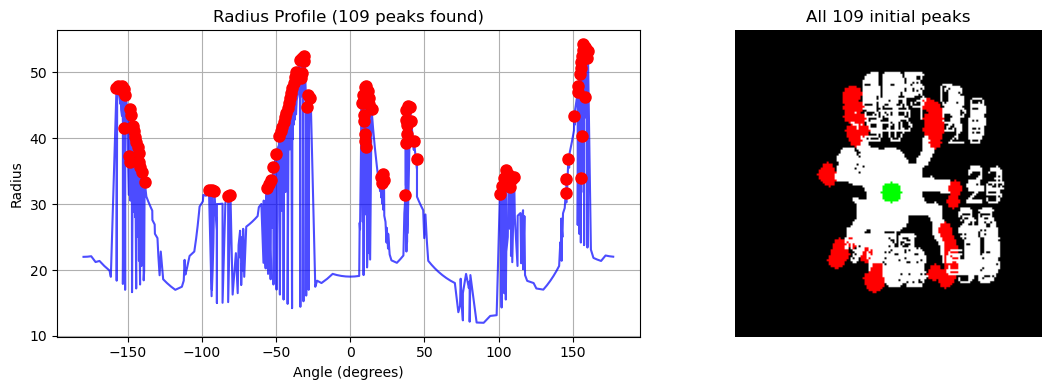

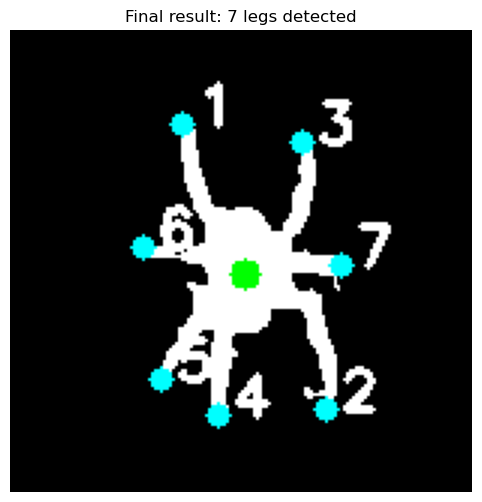

C:\Users\adamain\Downloads\cropped_frames\cropped_32 - 3.jpg


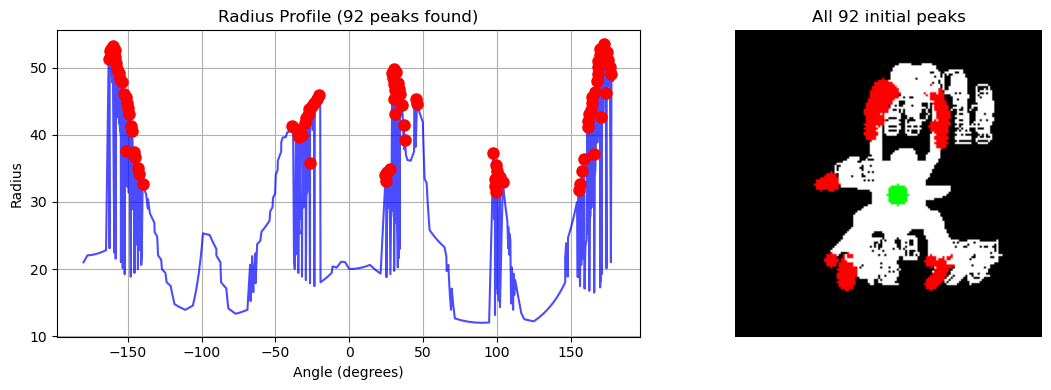

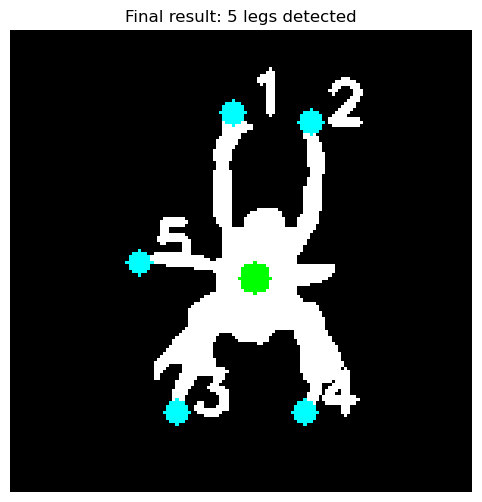

C:\Users\adamain\Downloads\cropped_frames\cropped_32 - C.jpg


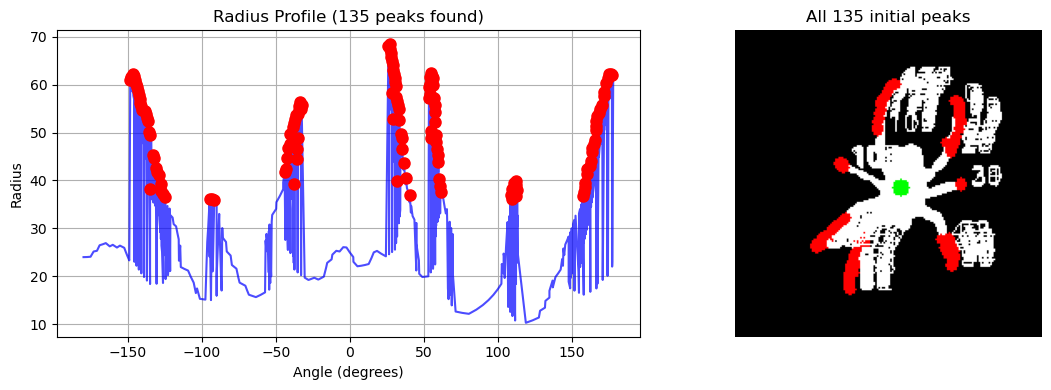

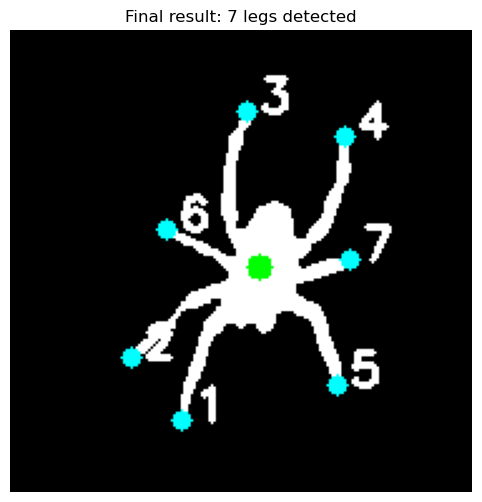

C:\Users\adamain\Downloads\cropped_frames\cropped_36 - 1.jpg


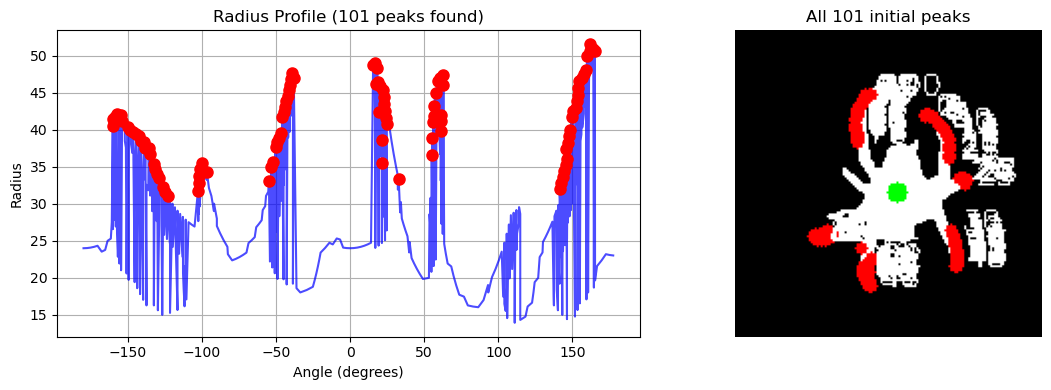

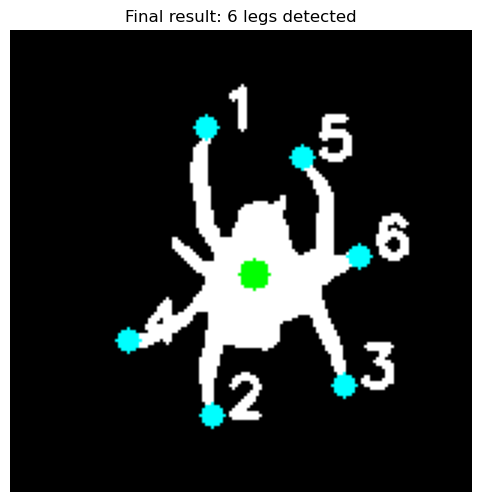

C:\Users\adamain\Downloads\cropped_frames\cropped_36 - 2.jpg


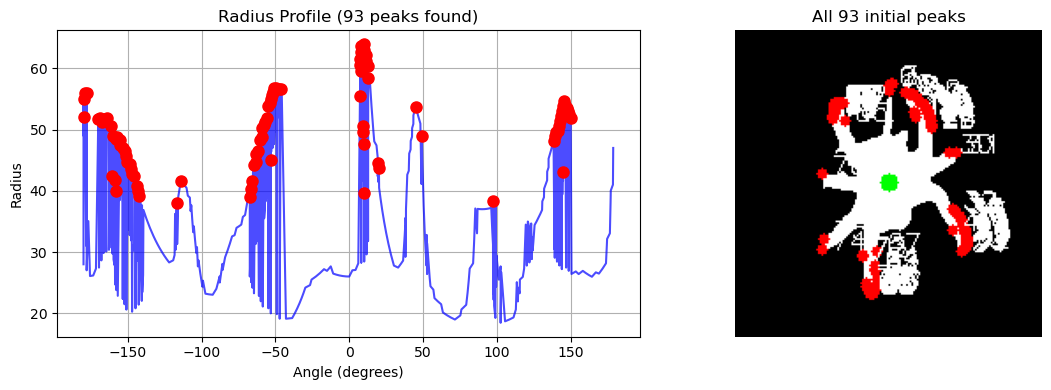

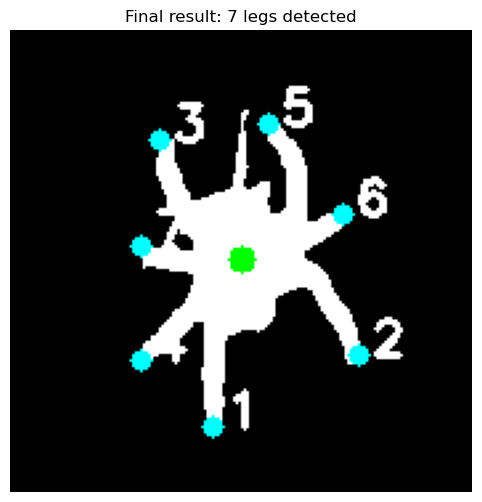

C:\Users\adamain\Downloads\cropped_frames\cropped_36 - 3.jpg


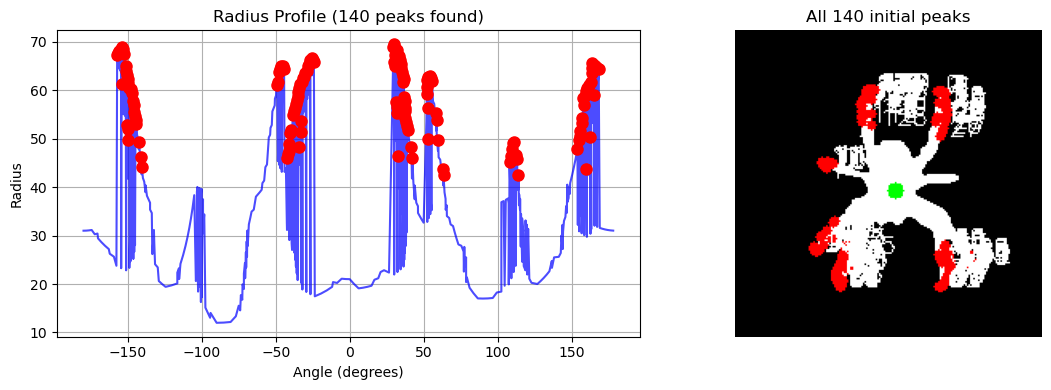

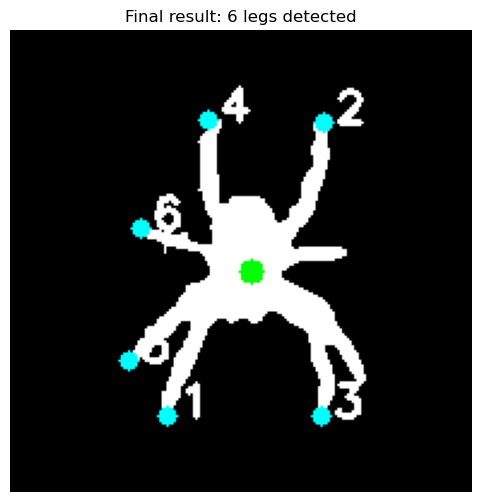

C:\Users\adamain\Downloads\cropped_frames\cropped_36 - C.jpg


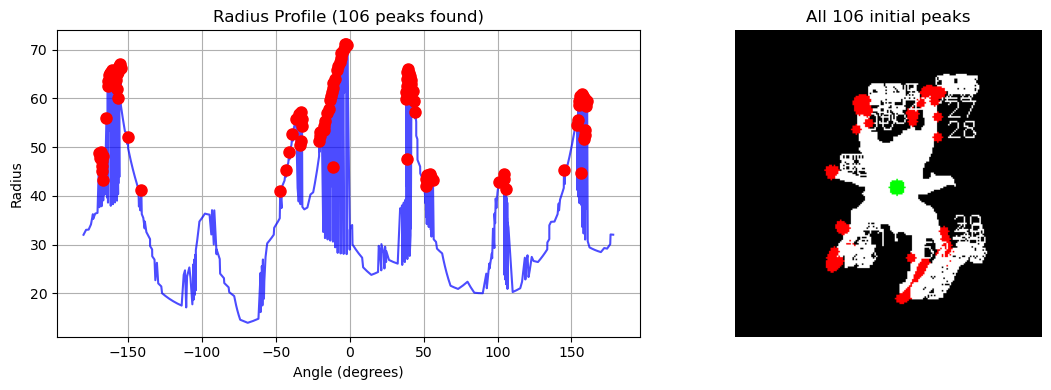

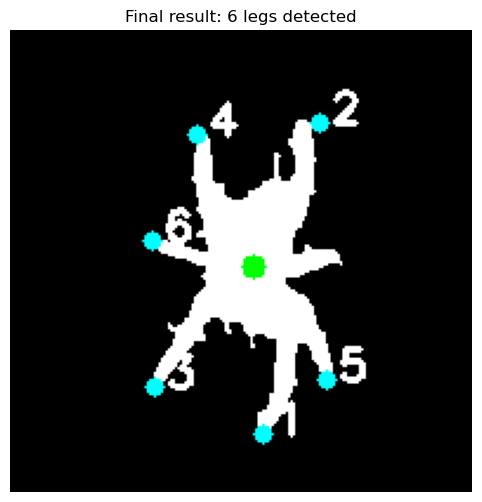

C:\Users\adamain\Downloads\cropped_frames\cropped_39 - 1.jpg


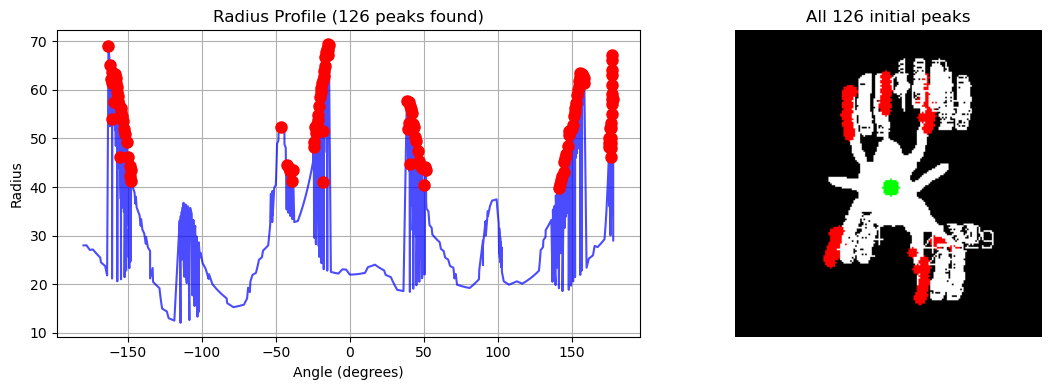

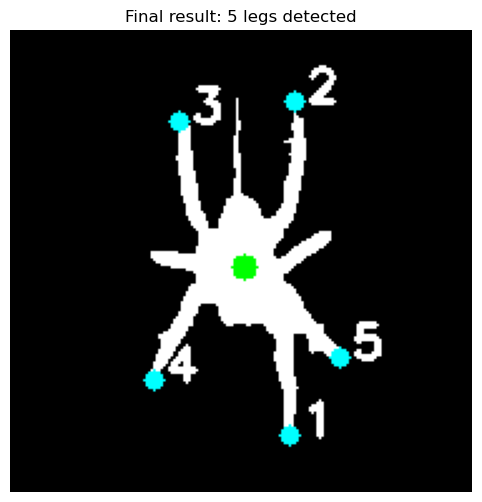

C:\Users\adamain\Downloads\cropped_frames\cropped_39 - 2.jpg


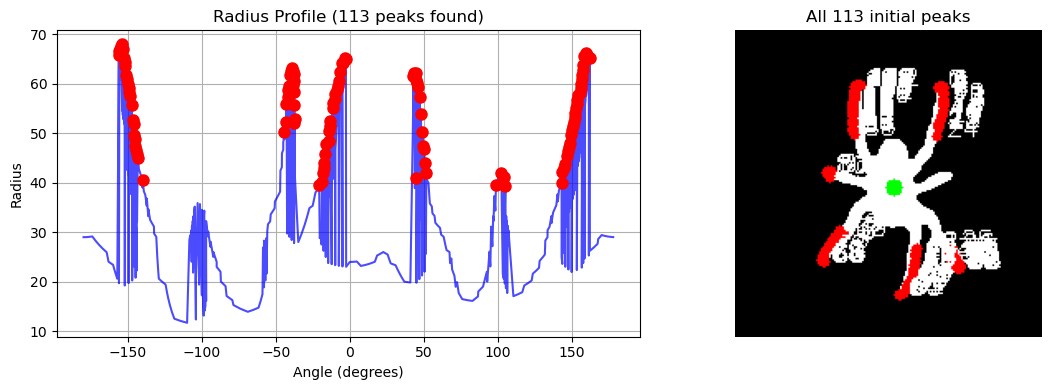

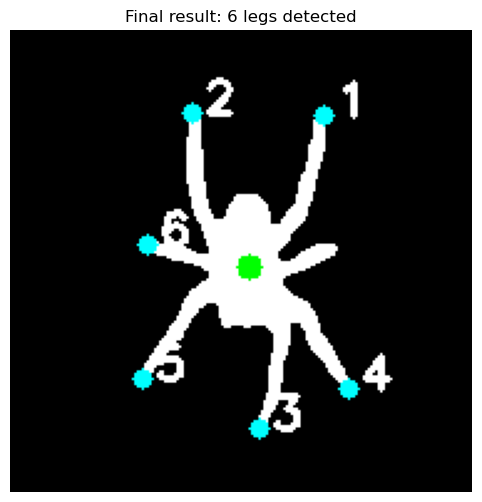

C:\Users\adamain\Downloads\cropped_frames\cropped_39 - 3.jpg


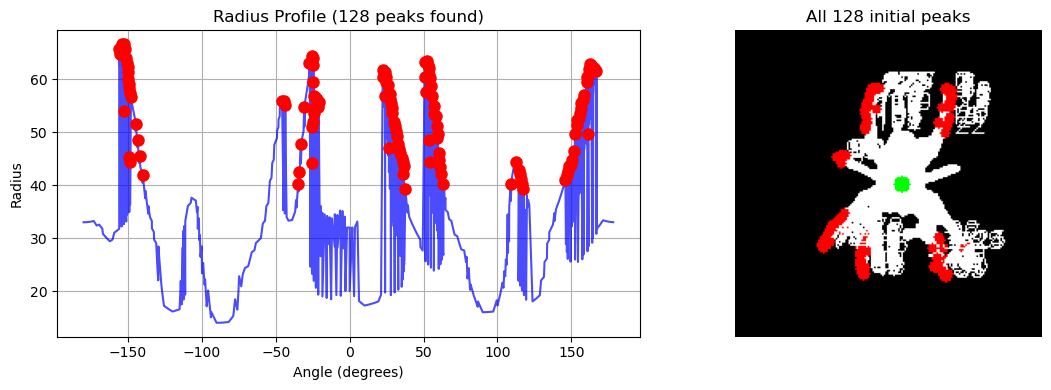

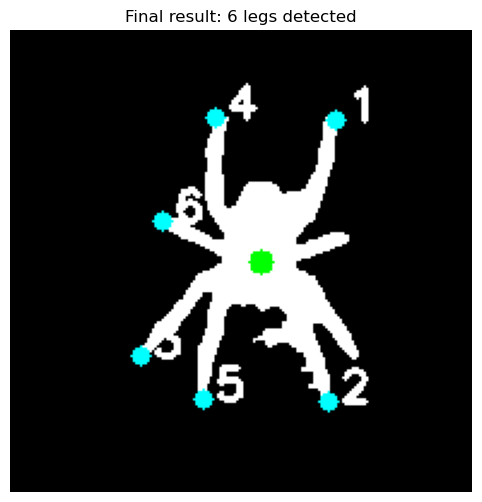

C:\Users\adamain\Downloads\cropped_frames\cropped_39 - C.jpg


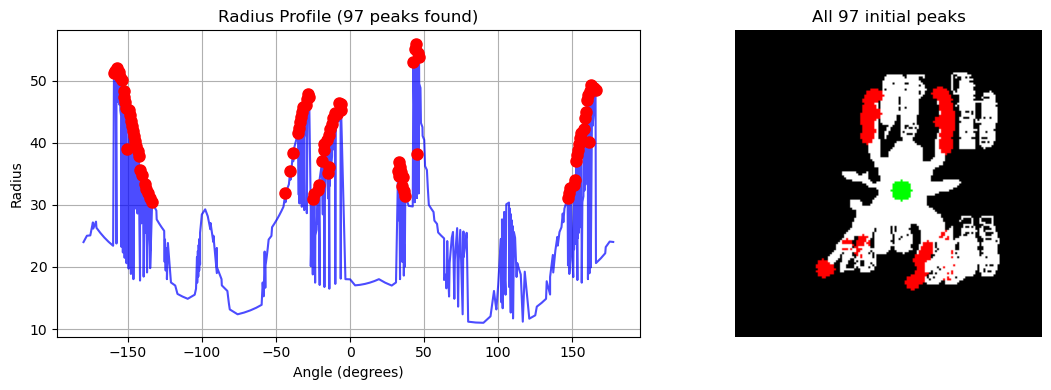

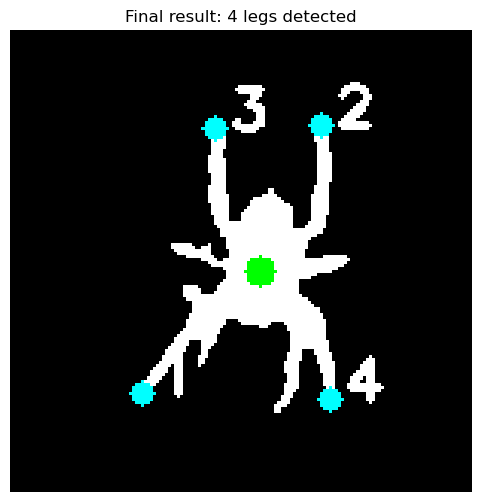

C:\Users\adamain\Downloads\cropped_frames\cropped_40 - 1.jpg


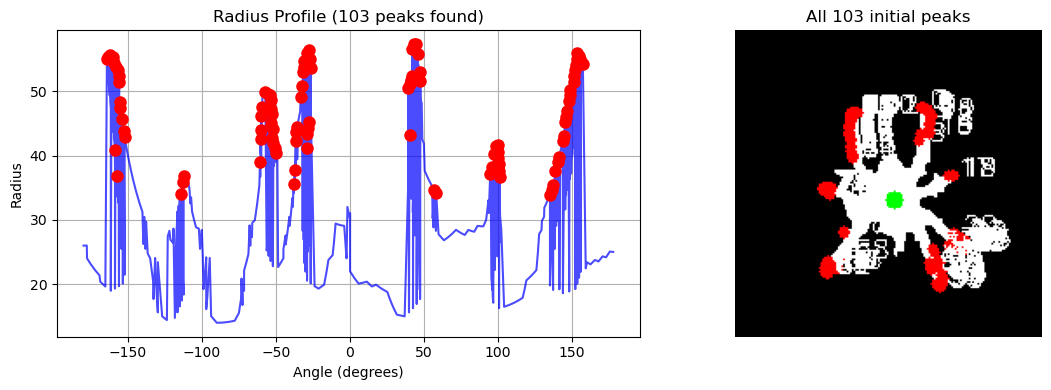

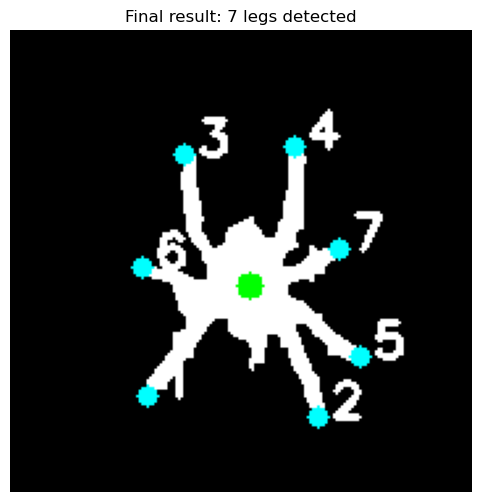

C:\Users\adamain\Downloads\cropped_frames\cropped_40 - 2.jpg


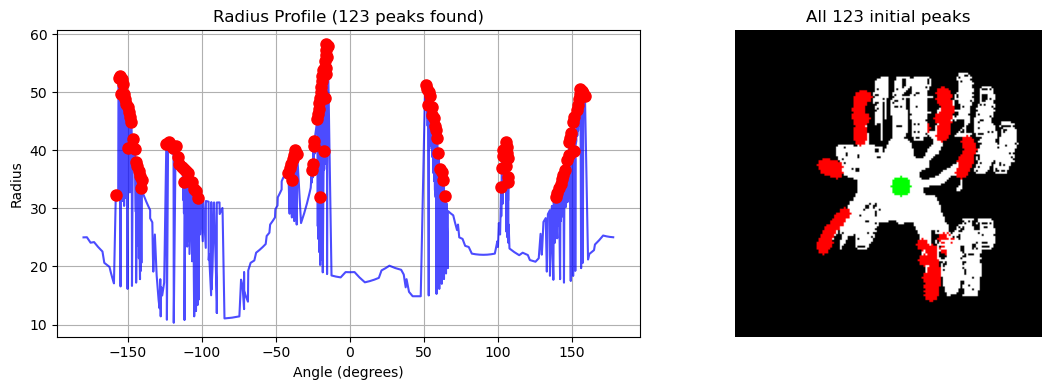

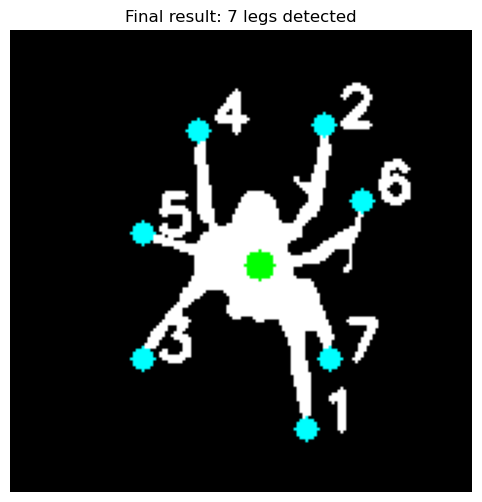

C:\Users\adamain\Downloads\cropped_frames\cropped_40 - 3.jpg


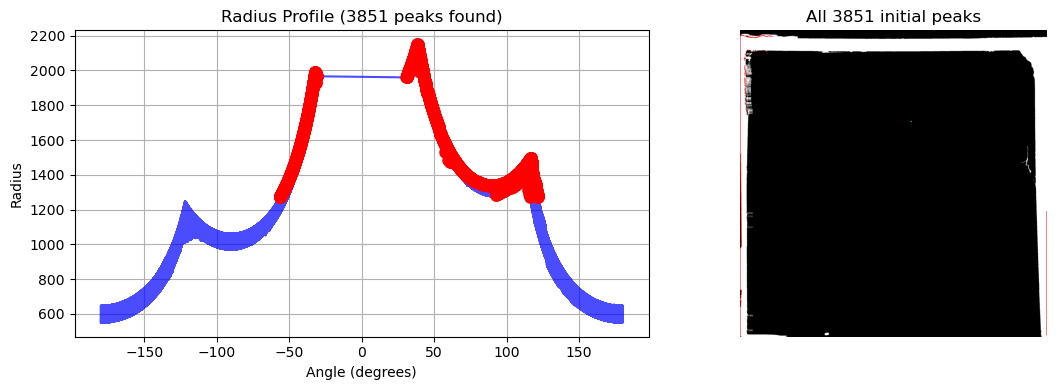

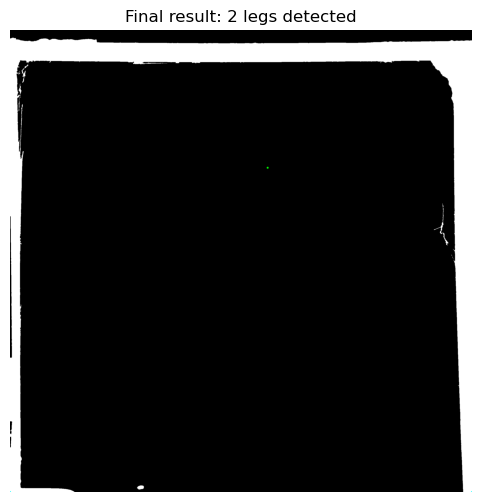

C:\Users\adamain\Downloads\cropped_frames\cropped_40 - C.jpg


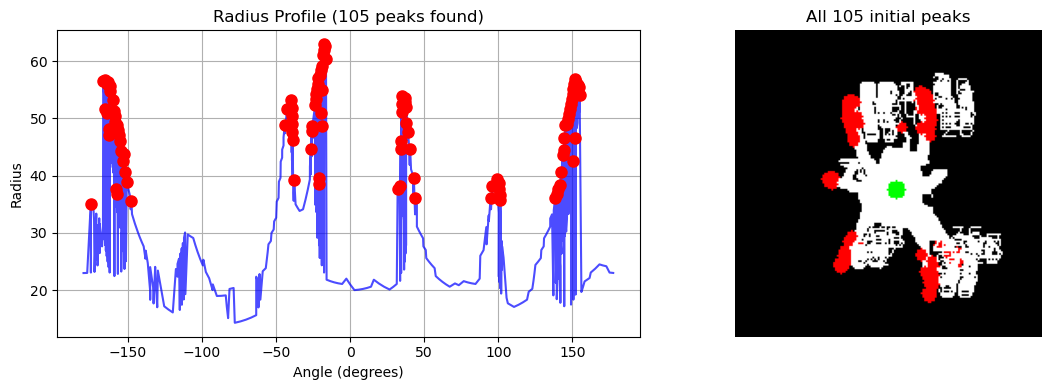

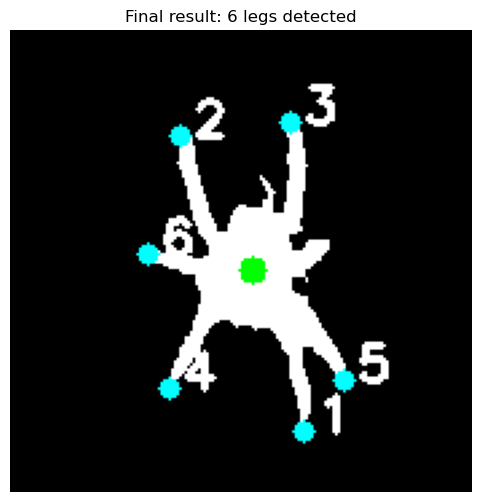

C:\Users\adamain\Downloads\cropped_frames\cropped_41 - 1.jpg


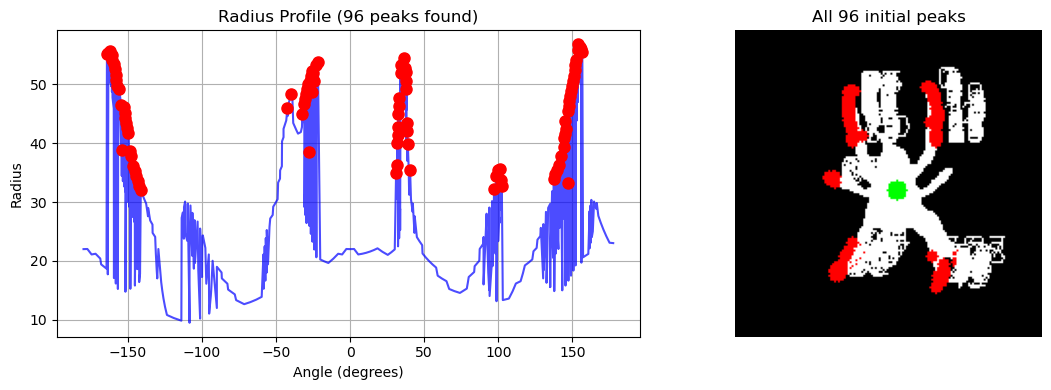

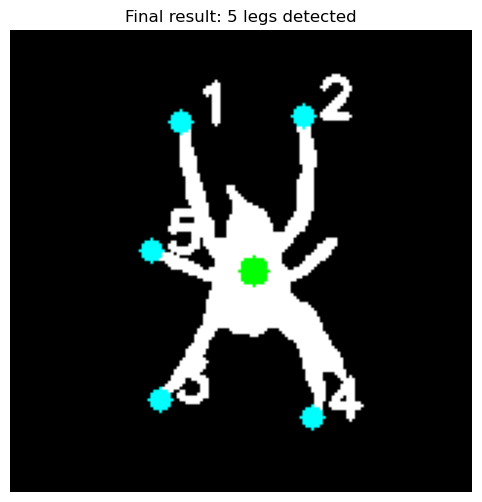

C:\Users\adamain\Downloads\cropped_frames\cropped_41 - 2.jpg


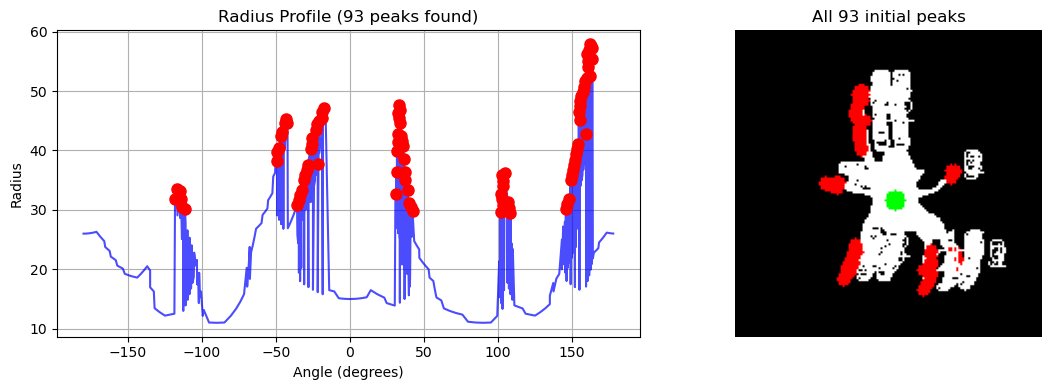

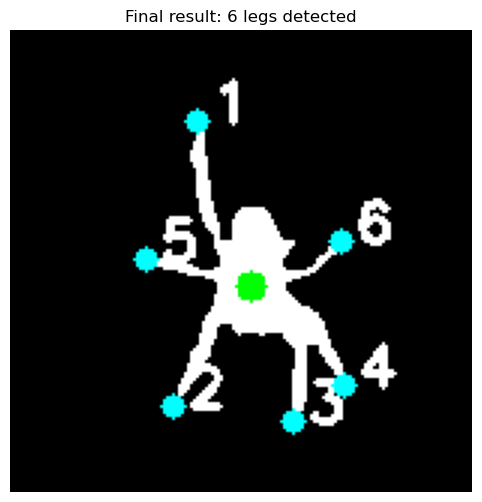

C:\Users\adamain\Downloads\cropped_frames\cropped_41 - 3.jpg


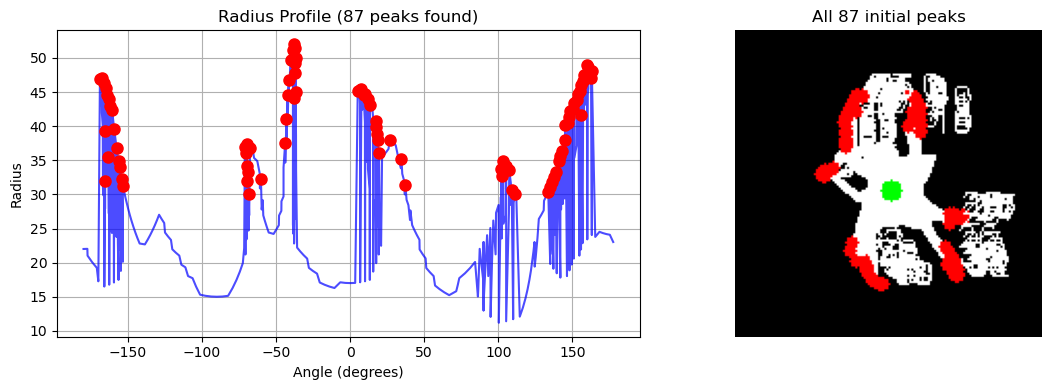

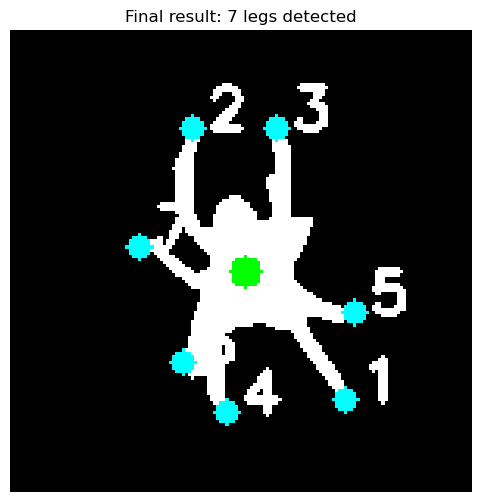

C:\Users\adamain\Downloads\cropped_frames\cropped_41 - C.jpg


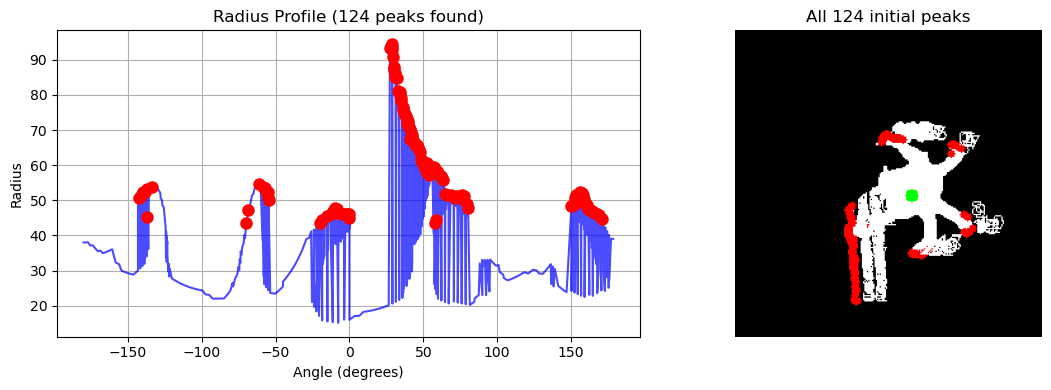

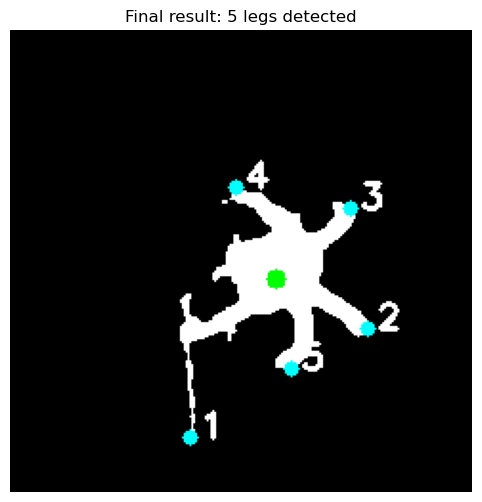

C:\Users\adamain\Downloads\cropped_frames\cropped_42 - 1.jpg


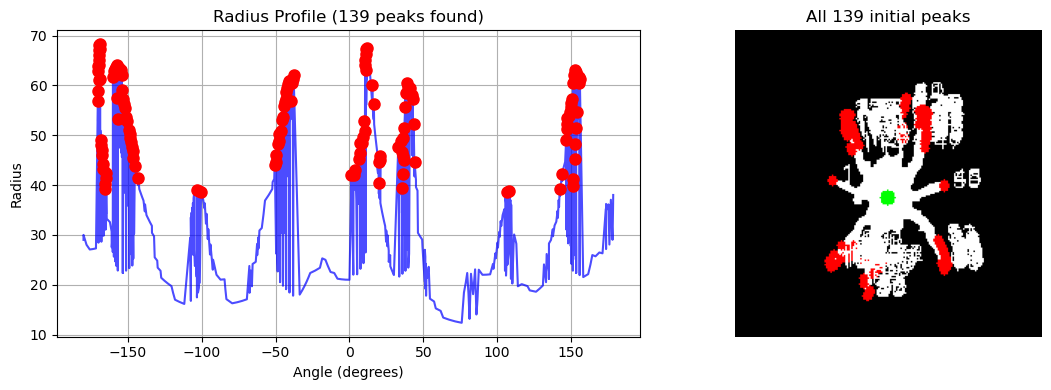

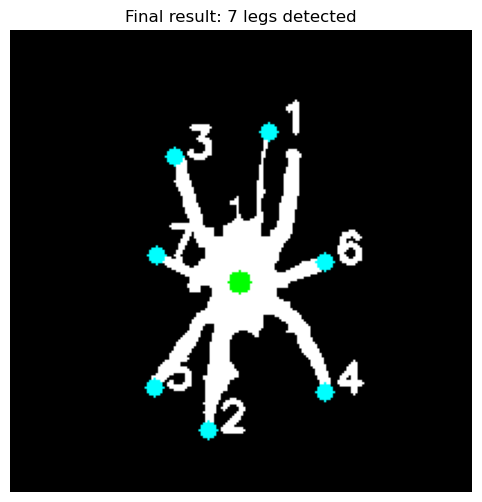

C:\Users\adamain\Downloads\cropped_frames\cropped_42 - 3.jpg


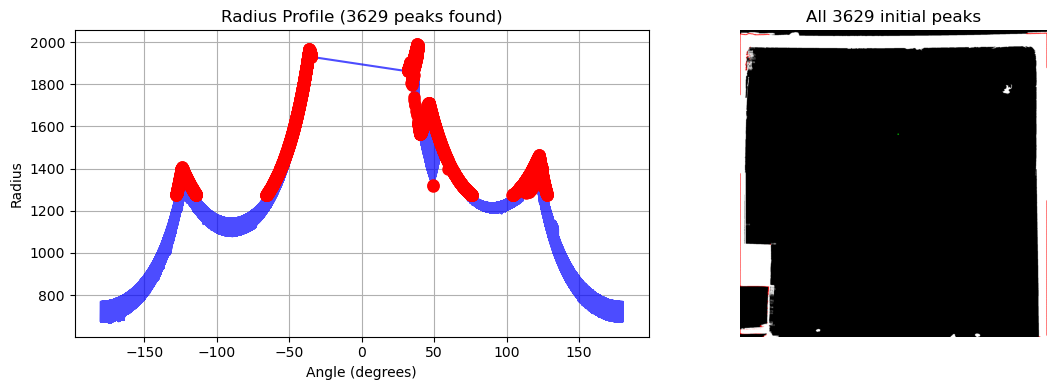

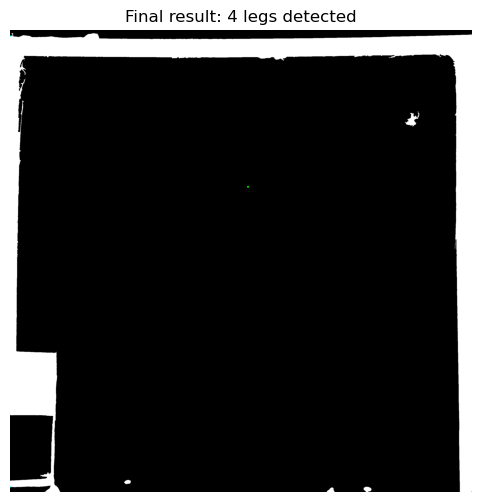

C:\Users\adamain\Downloads\cropped_frames\cropped_42 - C.jpg


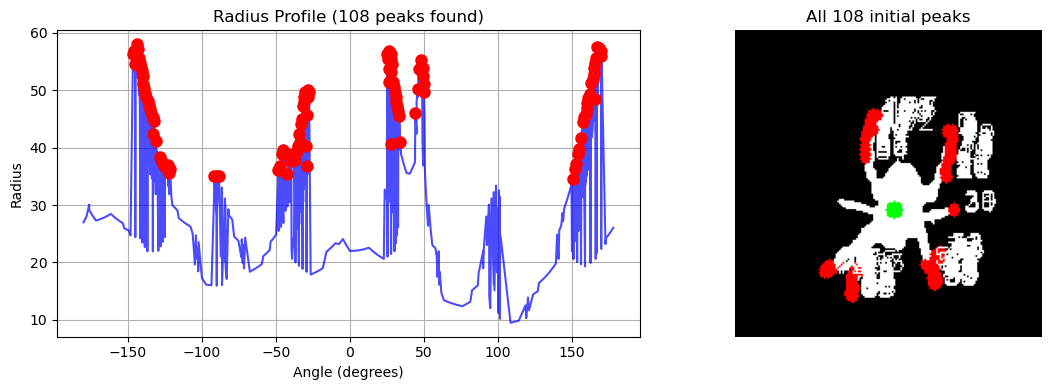

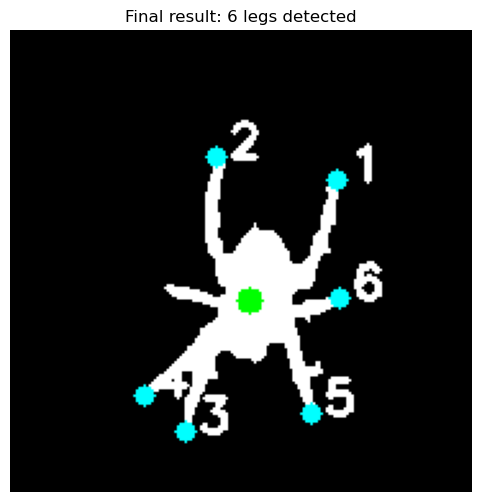

C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 1.jpg


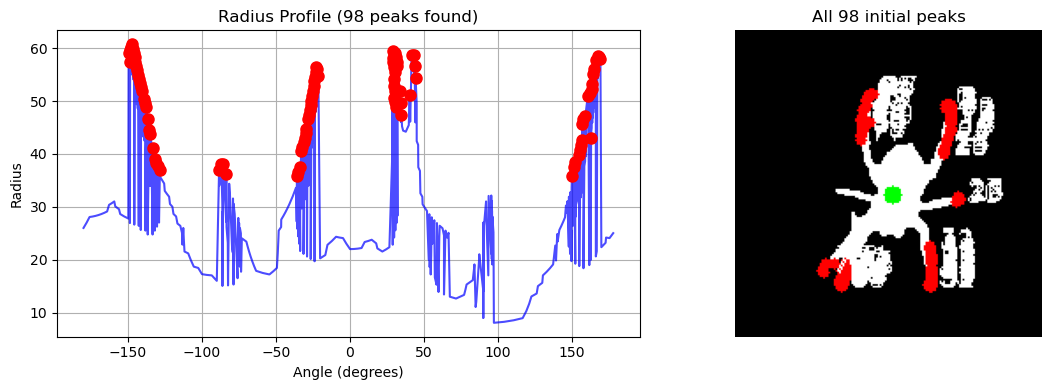

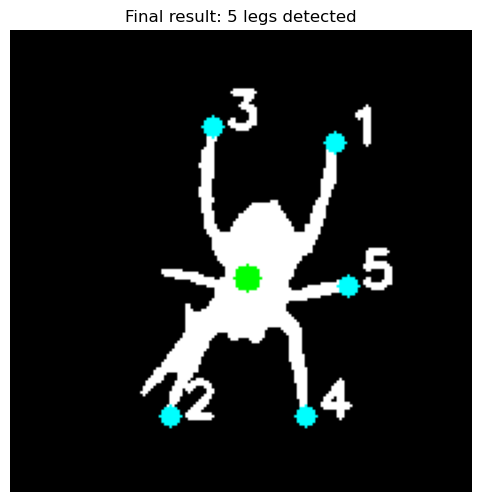

C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 2.jpg


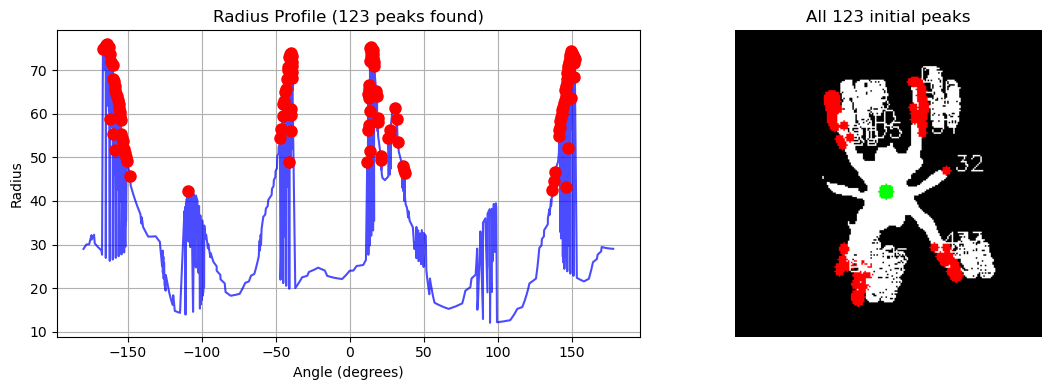

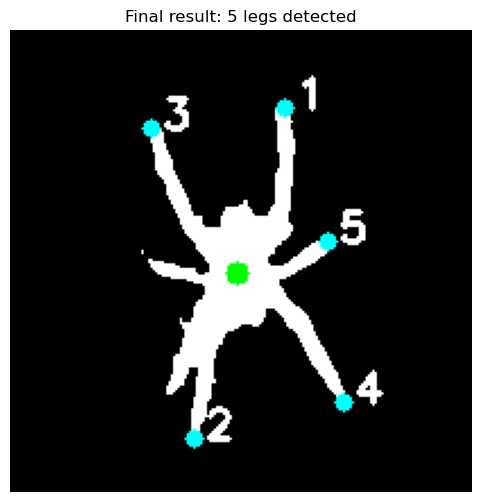

C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 3.jpg


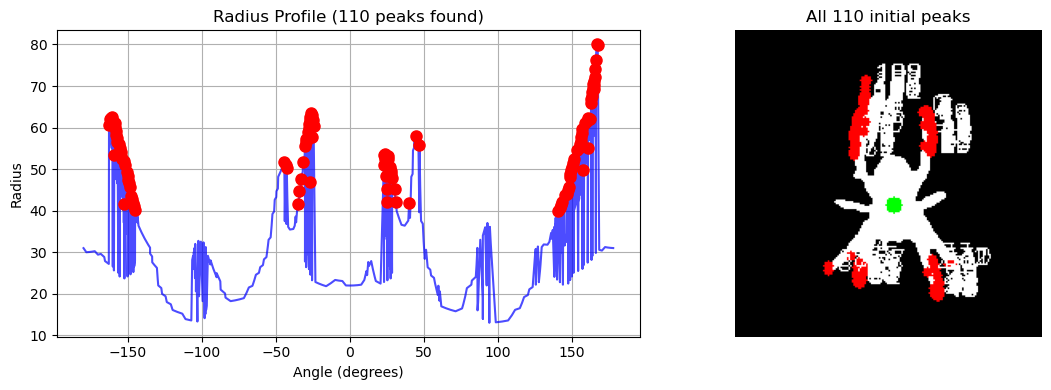

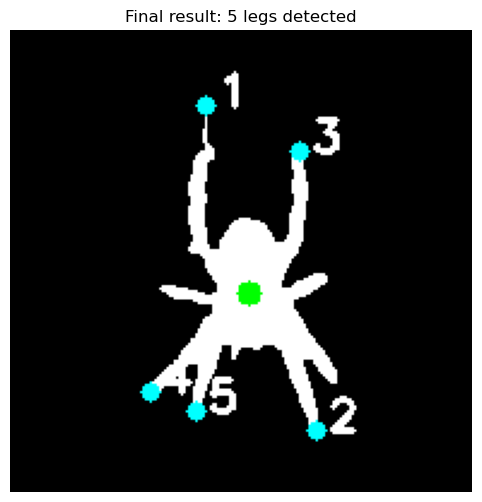

C:\Users\adamain\Downloads\cropped_frames\cropped_43 - C.jpg


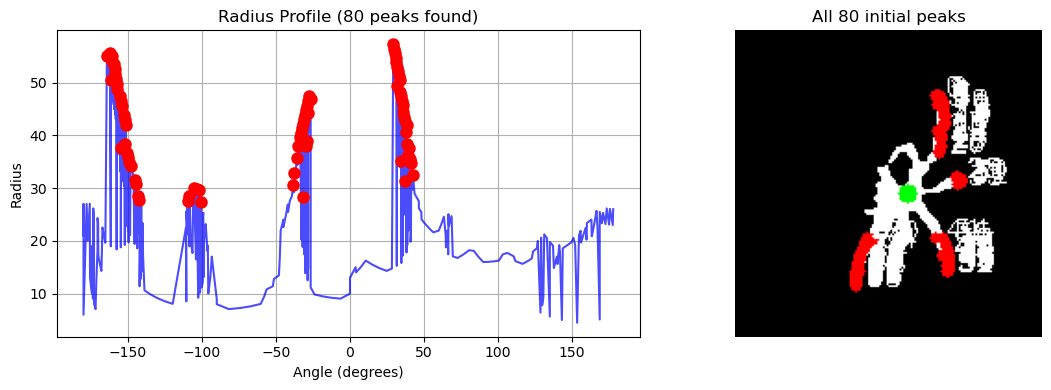

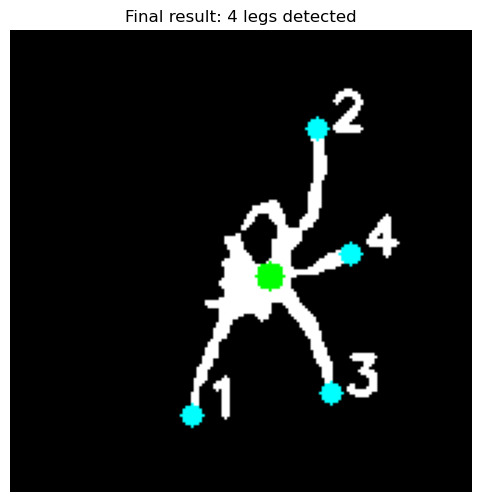

C:\Users\adamain\Downloads\cropped_frames\cropped_48 - 1.jpg


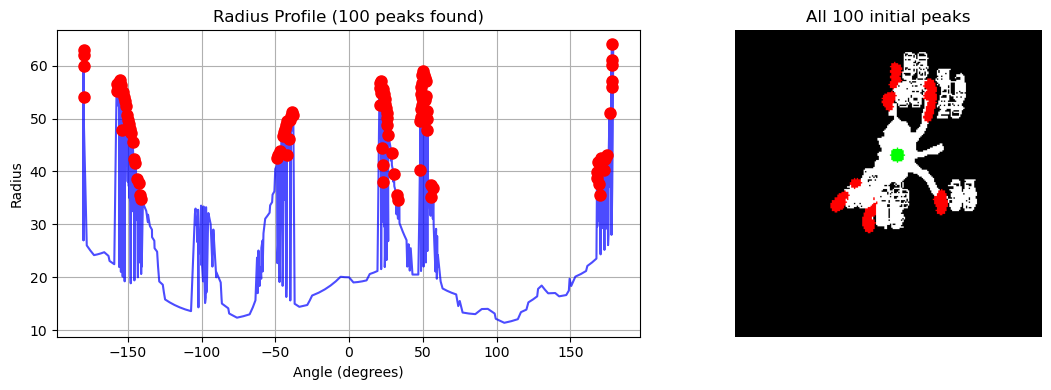

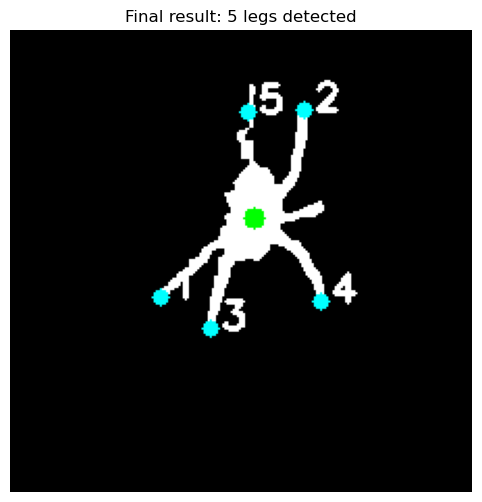

C:\Users\adamain\Downloads\cropped_frames\cropped_48 - 2.jpg


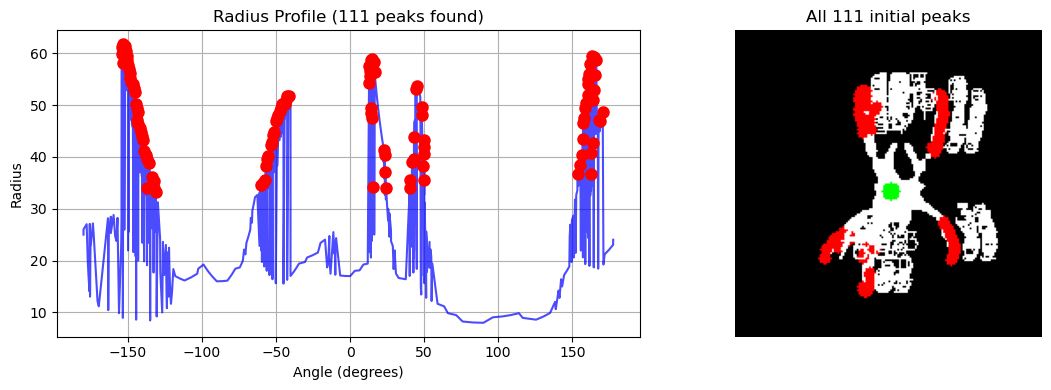

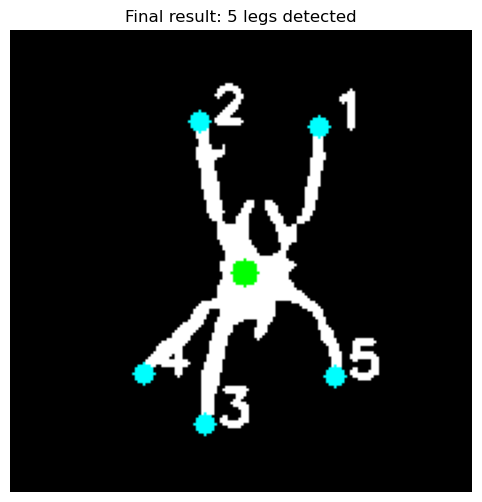

C:\Users\adamain\Downloads\cropped_frames\cropped_48 - 3.jpg


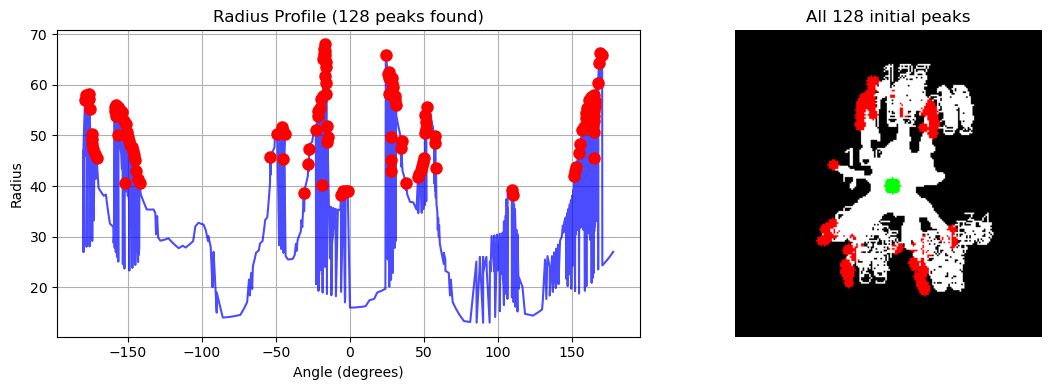

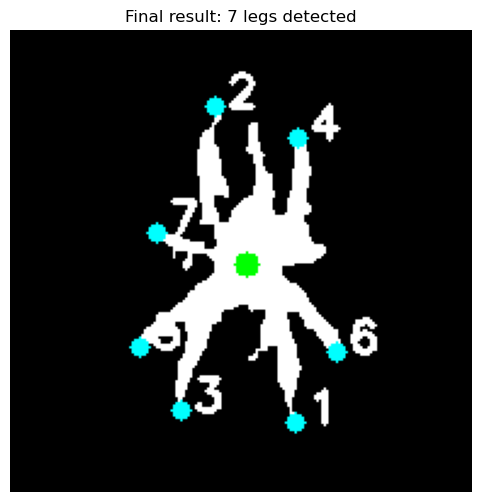

C:\Users\adamain\Downloads\cropped_frames\cropped_48 - C.jpg


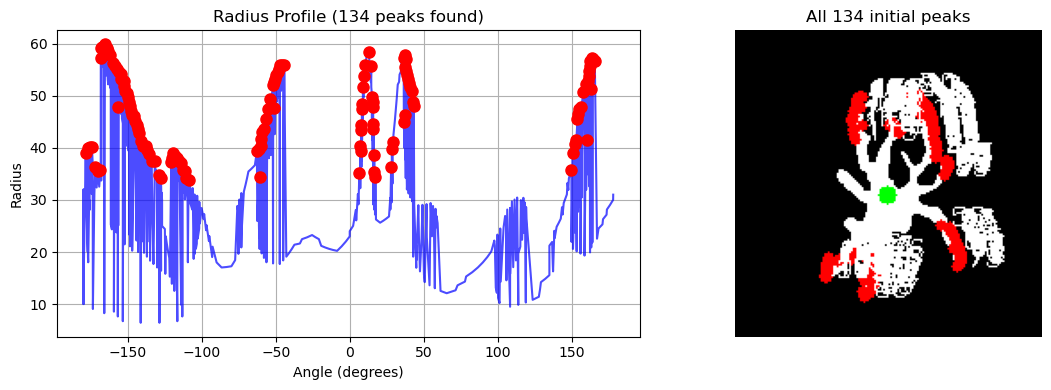

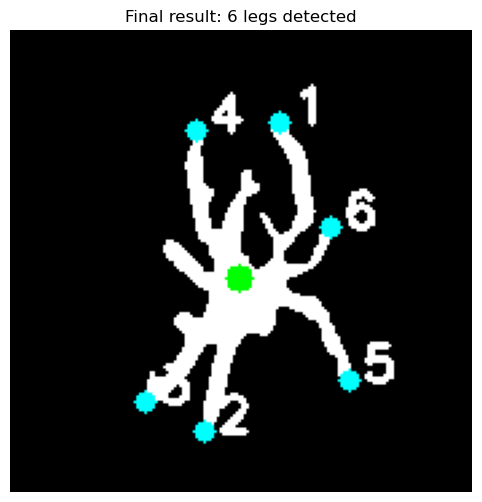

C:\Users\adamain\Downloads\cropped_frames\cropped_49 - 1.jpg


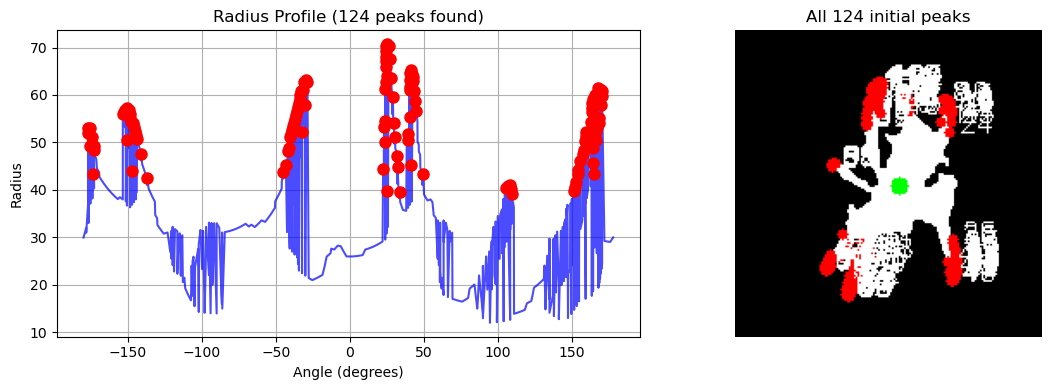

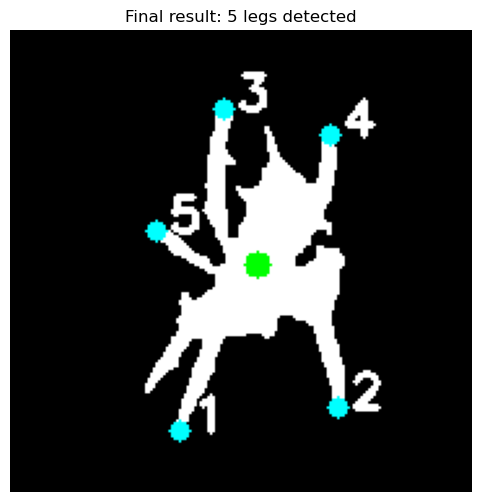

C:\Users\adamain\Downloads\cropped_frames\cropped_49 - 2.jpg


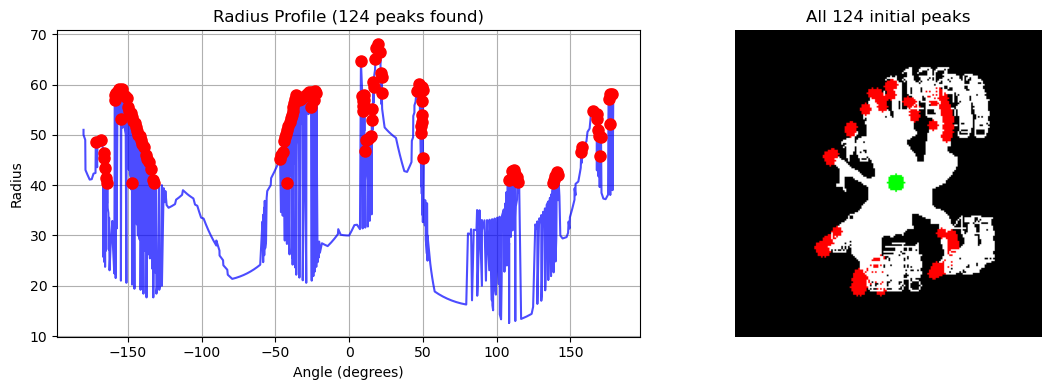

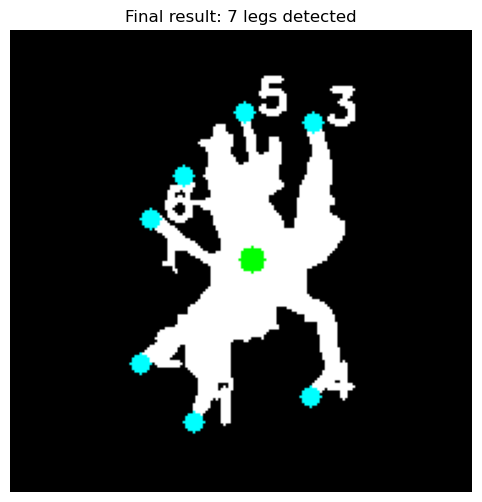

C:\Users\adamain\Downloads\cropped_frames\cropped_49 - 3.jpg


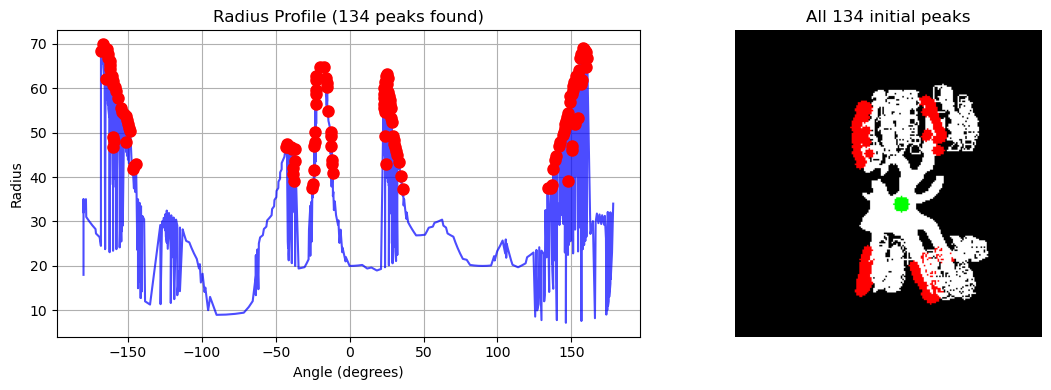

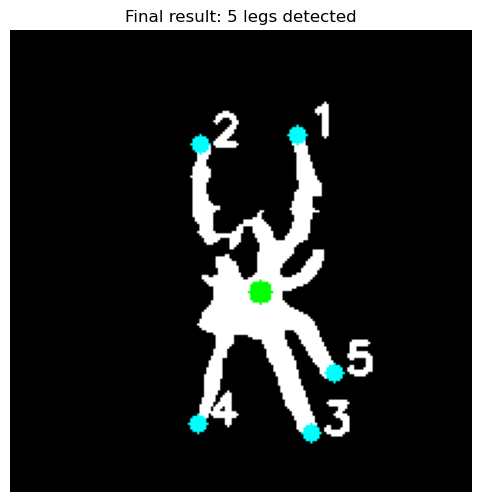

C:\Users\adamain\Downloads\cropped_frames\cropped_49 - C.jpg


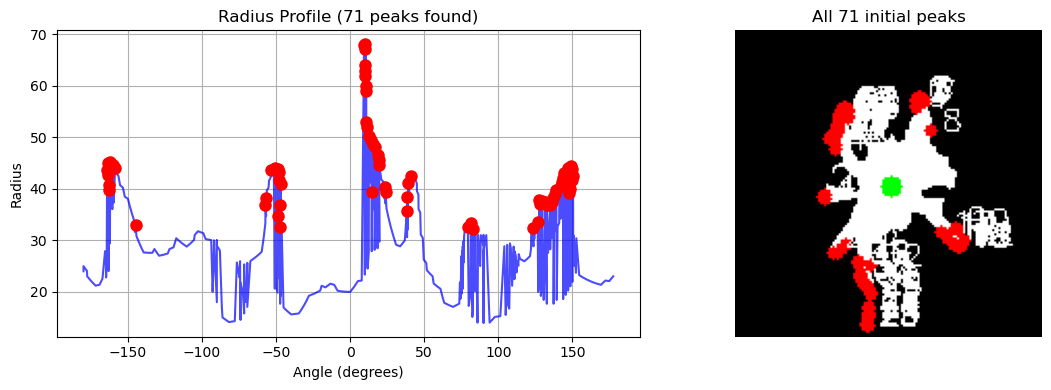

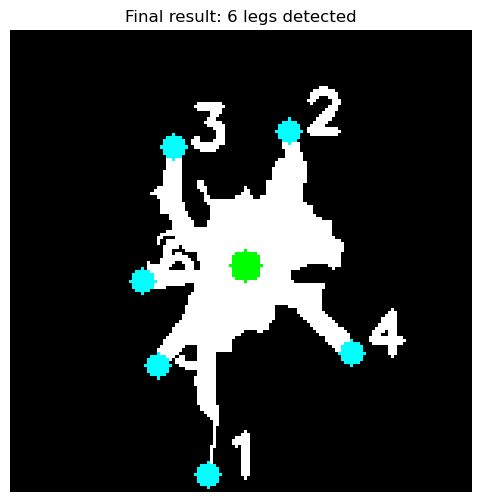

C:\Users\adamain\Downloads\cropped_frames\cropped_50 - 1.jpg


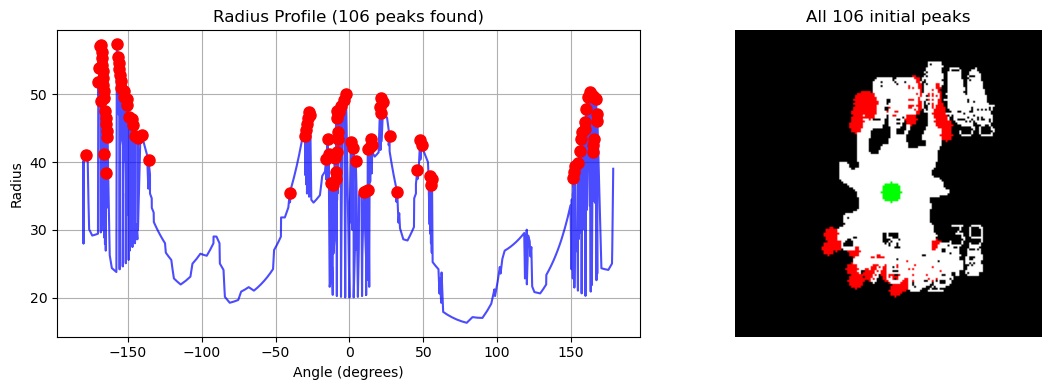

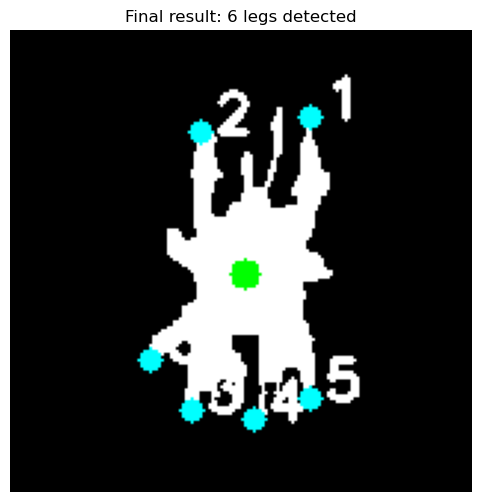

C:\Users\adamain\Downloads\cropped_frames\cropped_50 - 2.jpg


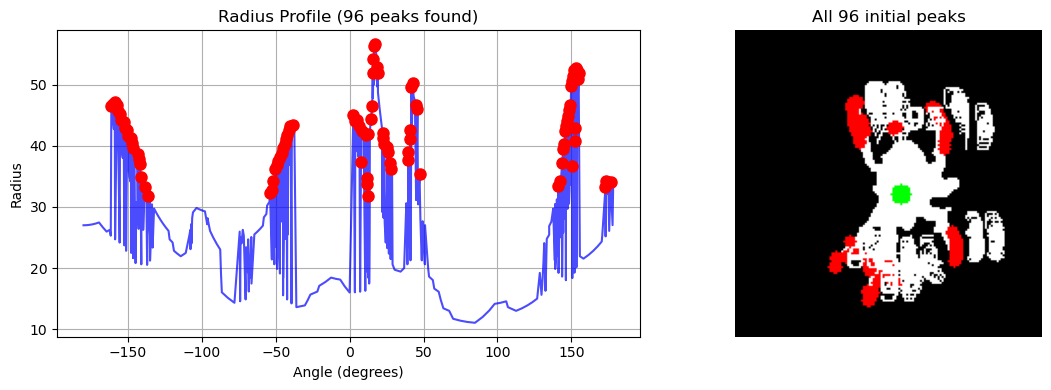

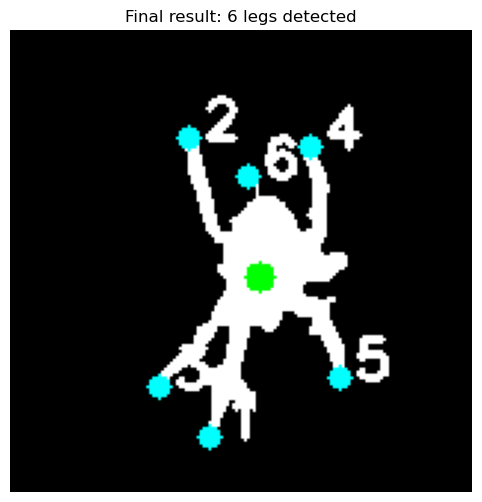

C:\Users\adamain\Downloads\cropped_frames\cropped_50 - 3.jpg


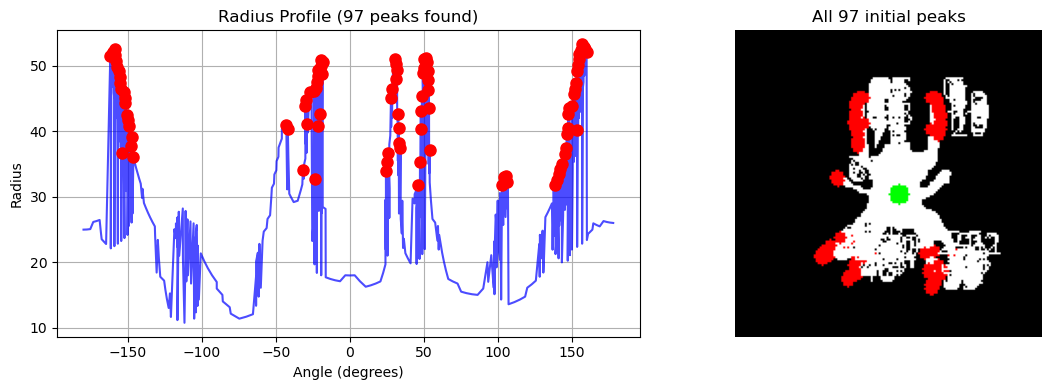

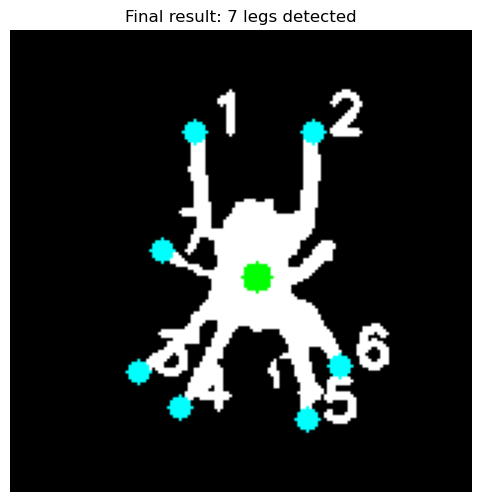

C:\Users\adamain\Downloads\cropped_frames\cropped_50 - C.jpg


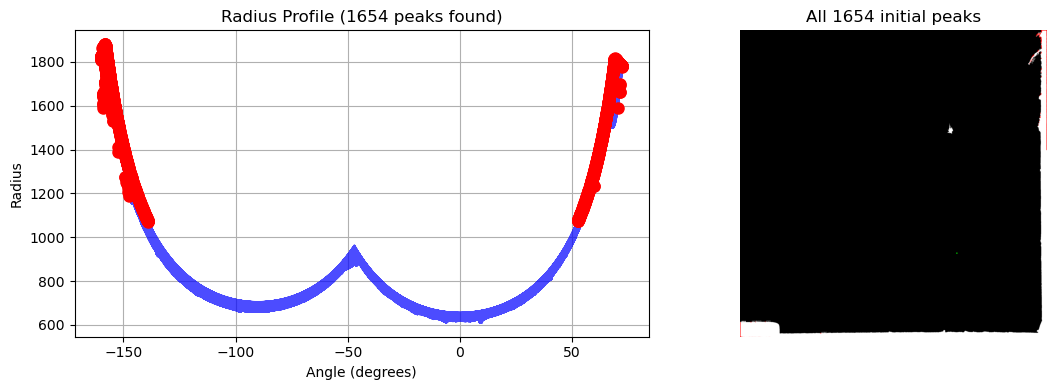

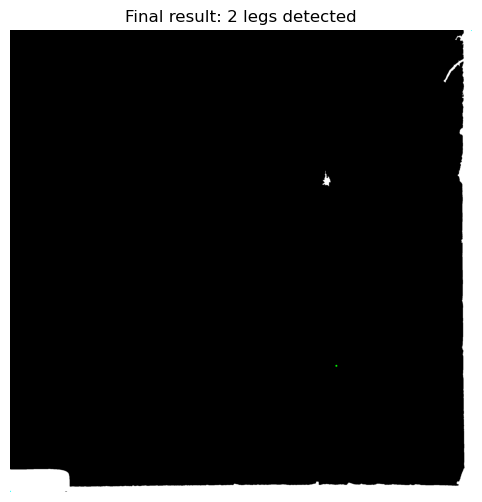

C:\Users\adamain\Downloads\cropped_frames\cropped_56 - 2.jpg


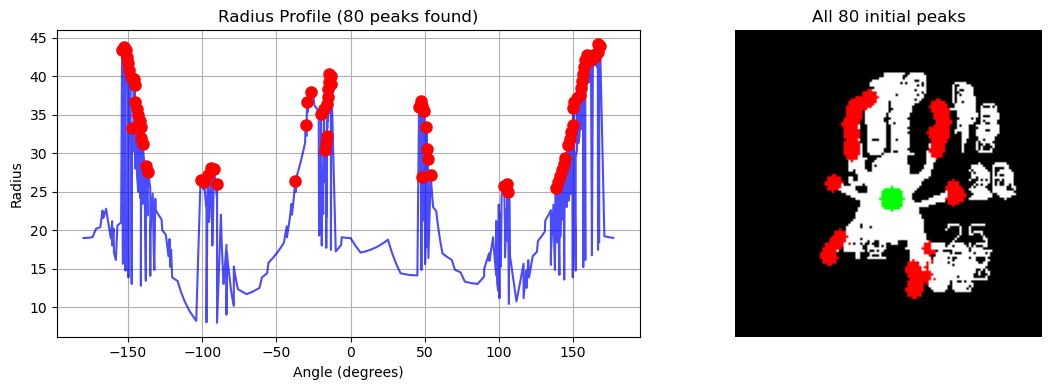

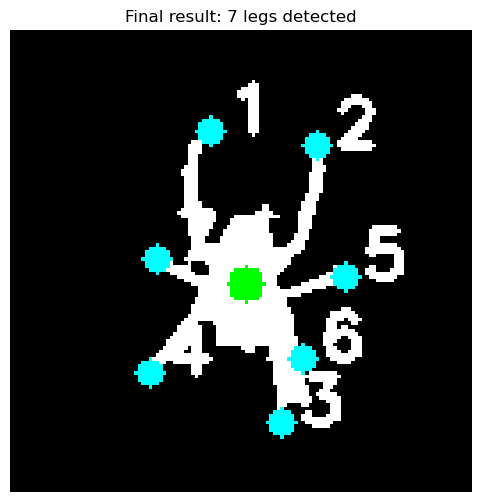

C:\Users\adamain\Downloads\cropped_frames\cropped_56 - 3.jpg


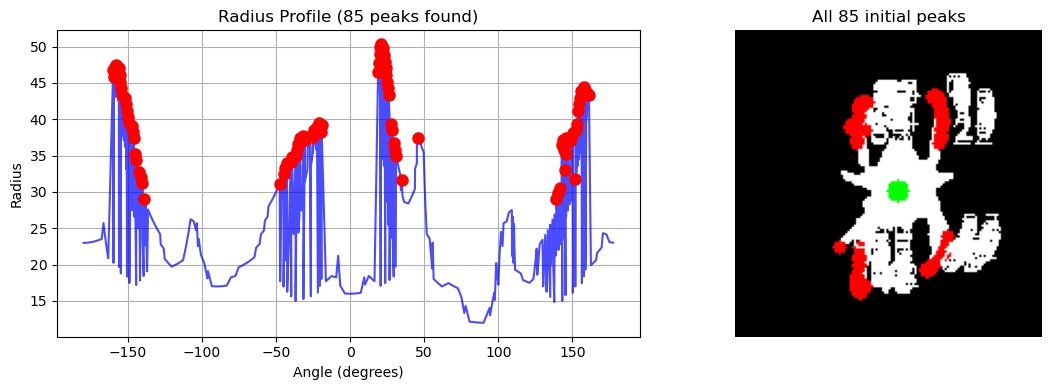

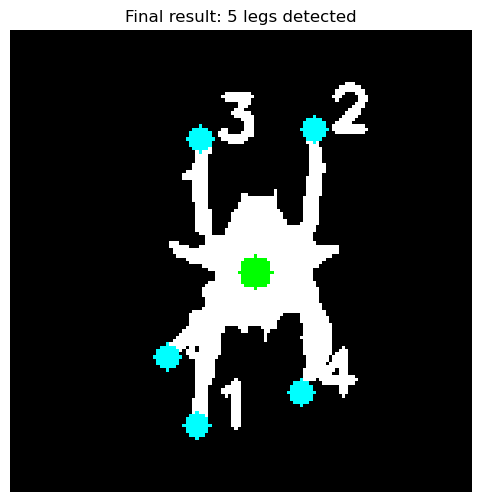

C:\Users\adamain\Downloads\cropped_frames\cropped_56 - C.jpg


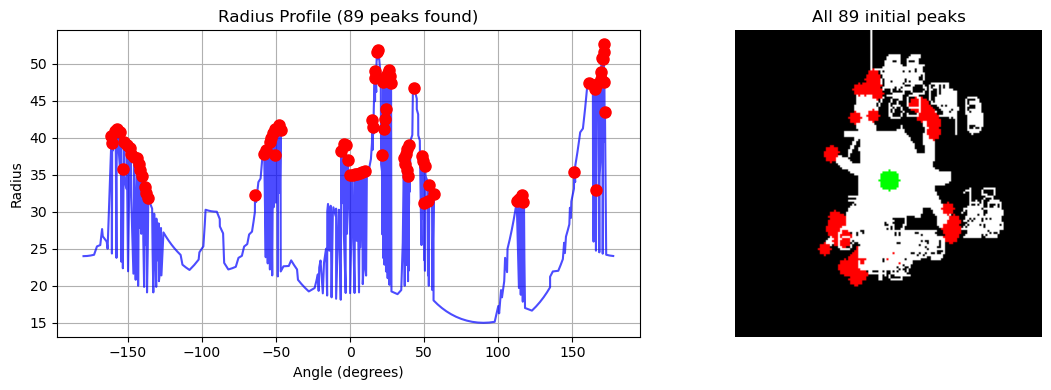

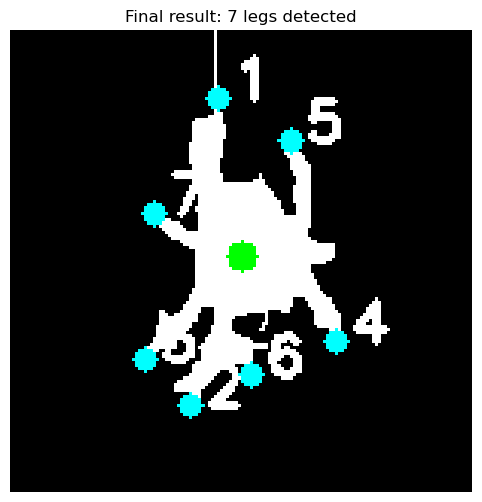

C:\Users\adamain\Downloads\cropped_frames\cropped_58 - 1.jpg


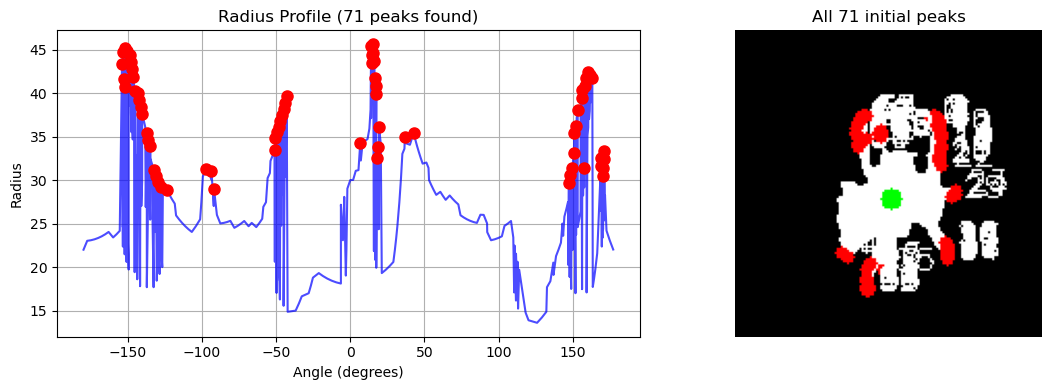

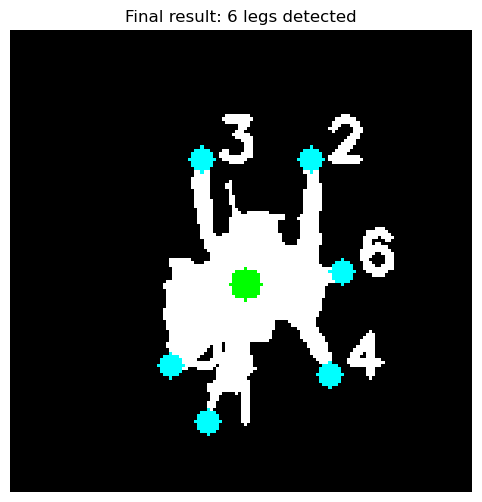

C:\Users\adamain\Downloads\cropped_frames\cropped_58 - 2.jpg


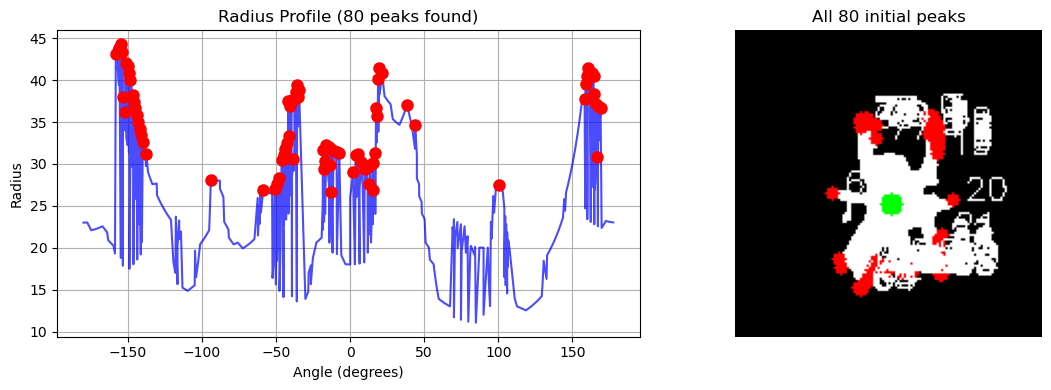

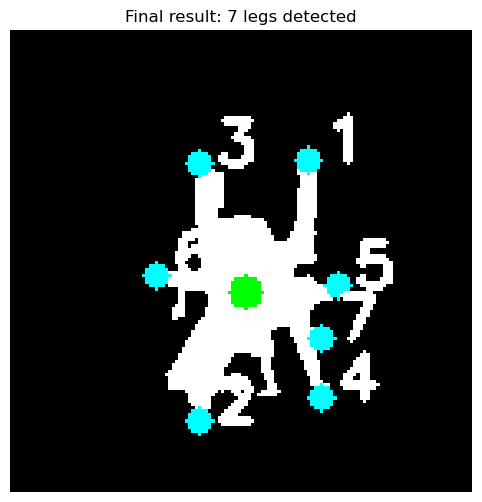

C:\Users\adamain\Downloads\cropped_frames\cropped_58 - 3.jpg


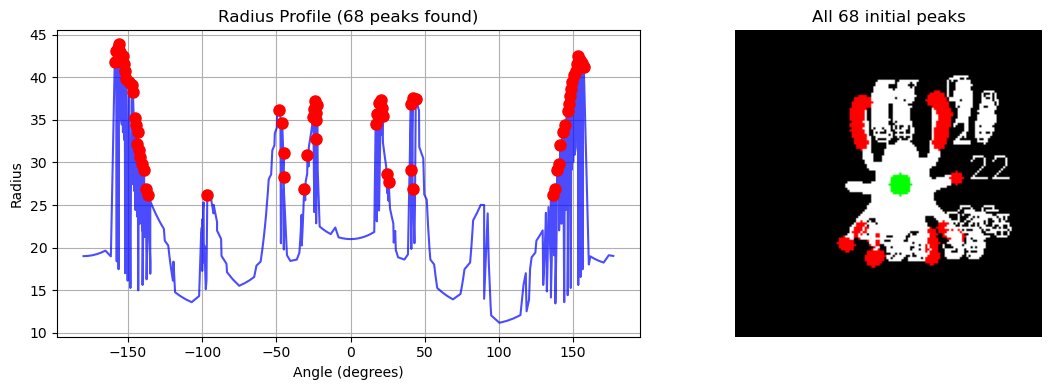

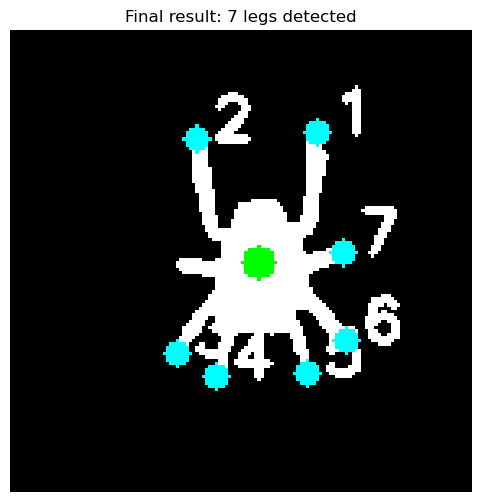

C:\Users\adamain\Downloads\cropped_frames\cropped_58 - C.jpg


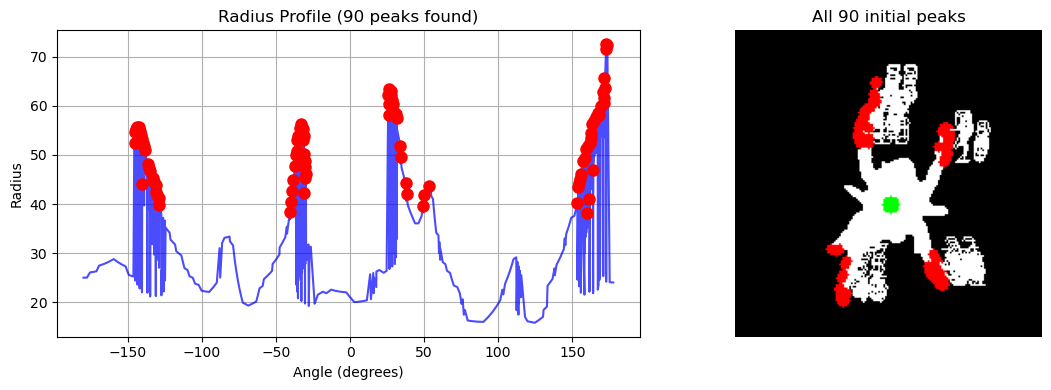

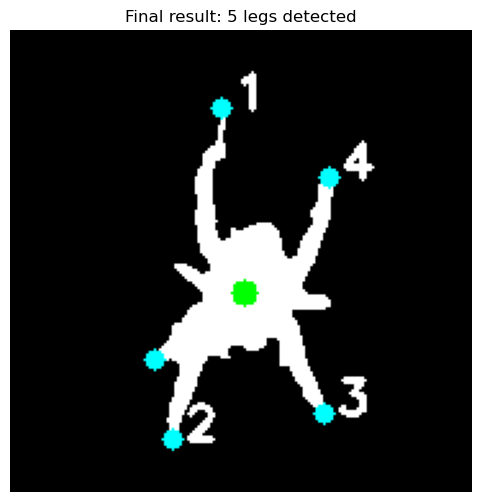

C:\Users\adamain\Downloads\cropped_frames\cropped_9 - 1.jpg


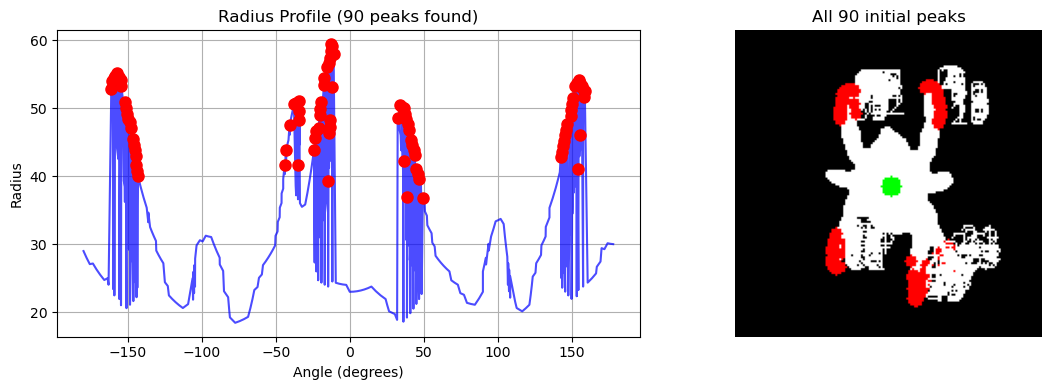

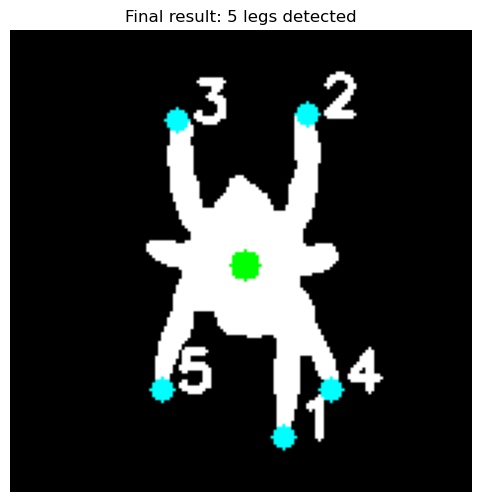

C:\Users\adamain\Downloads\cropped_frames\cropped_9 - 2.jpg


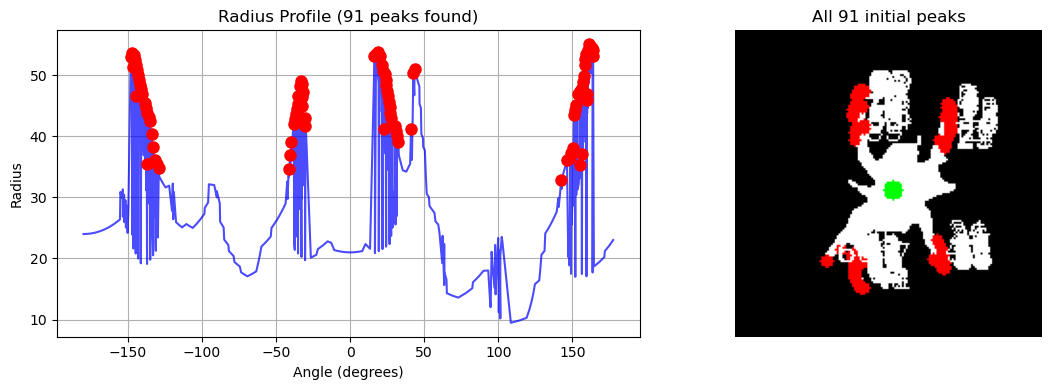

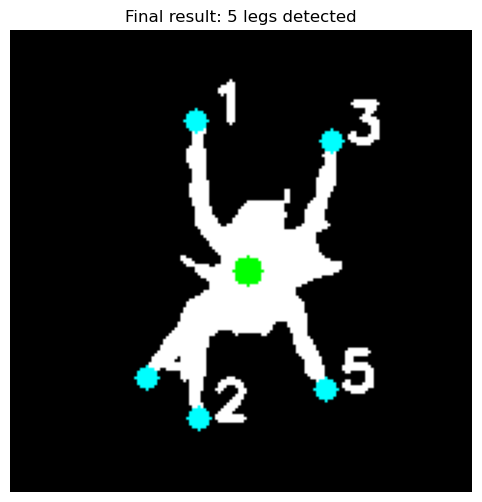

C:\Users\adamain\Downloads\cropped_frames\cropped_9 - 3.jpg


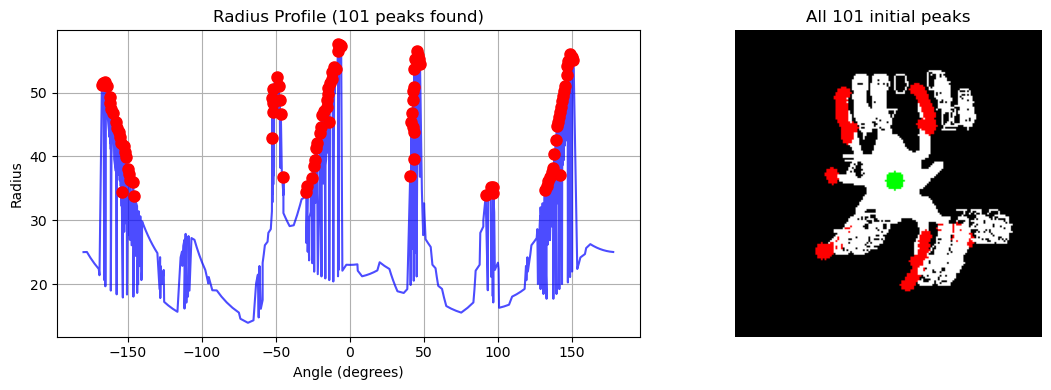

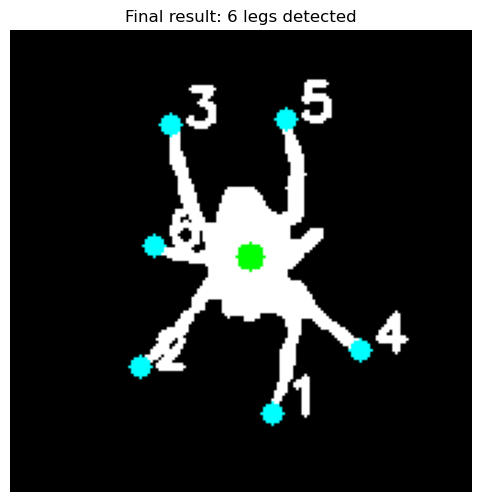

C:\Users\adamain\Downloads\cropped_frames\cropped_9 - 4.jpg


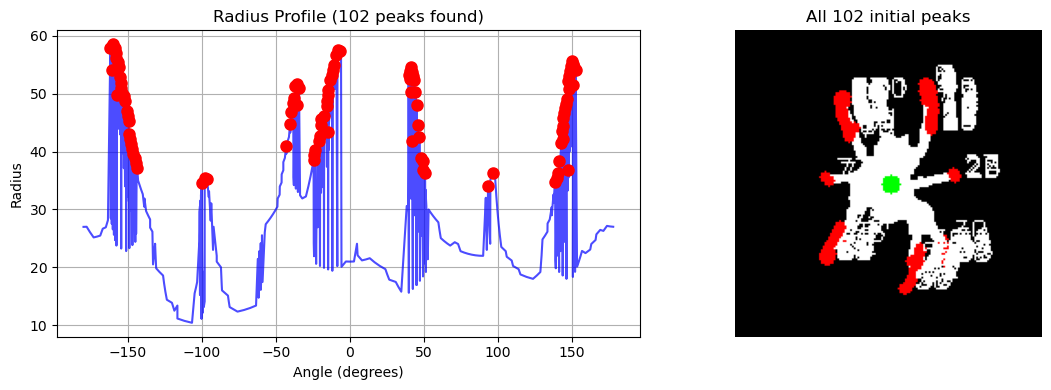

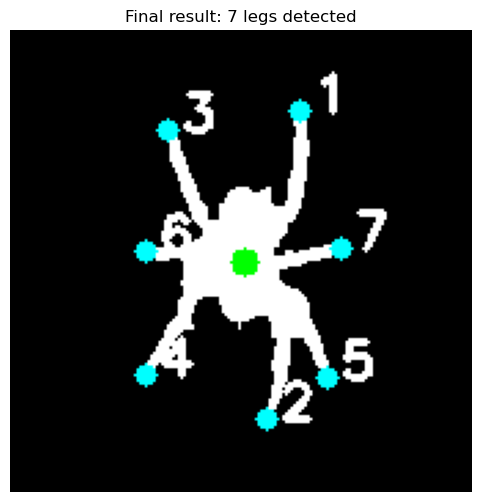

C:\Users\adamain\Downloads\cropped_frames\cropped_9 - 5.jpg


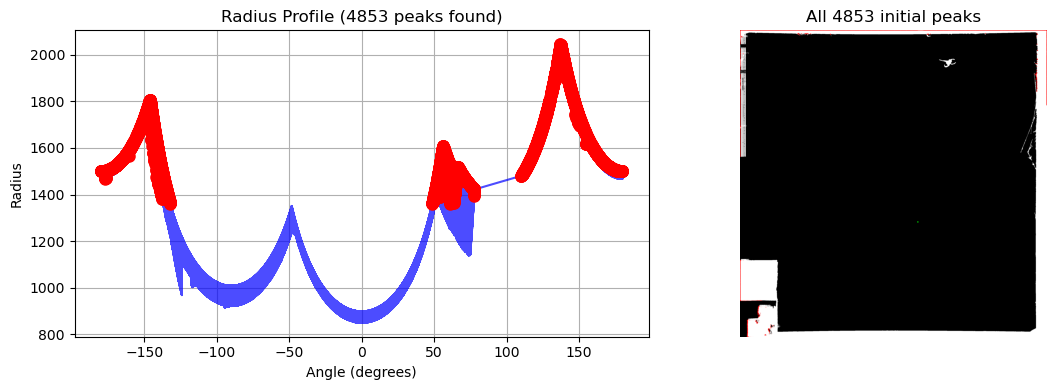

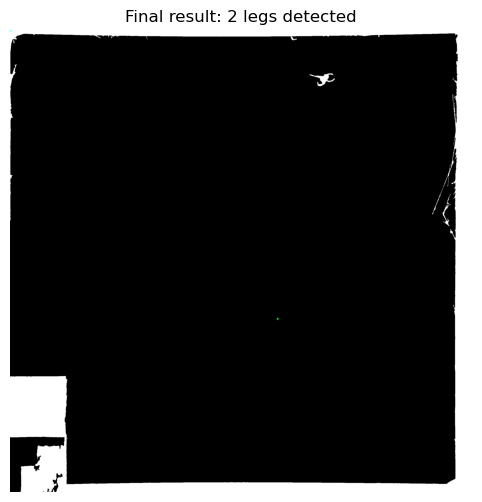

C:\Users\adamain\Downloads\cropped_frames\cropped_9 - C.jpg


In [18]:
import os
output_dir = r"C:\Users\adamain\Downloads\SpiderCrops\Trial 3 - Mean Sorting"
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

leg_numbers = []
for image in image_paths:
    frame = cv2.imread(image)
    thresholded = process_image(frame)
    
    mask, bbox = find_spider_with_dino_and_sam(
        full_image=thresholded,
        reference_mask=reference,
        dino_model=dino_model,
        dino_processor=dino_processor,
        sam_predictor=sam2_predictor
    )
    
    # Get image base name
    base_name = os.path.basename(image)
    name_without_ext = os.path.splitext(base_name)[0]
    
    crop, cropMask = crop_to_mask_circle(thresholded, mask)

    # Save the crop
    crop_path = os.path.join(output_dir, f"{name_without_ext}_crop.png")
    cv2.imwrite(crop_path, crop)

    processed = process_spider(crop)
    leg_numbers.append(count_spider_legs(processed, show_image=True, preprocess = False, output_dir = r"C:\Users\adamain\Downloads\SpiderLegs\Trial 3 - Mean Sorting", base_name = base_name))
    print(image)

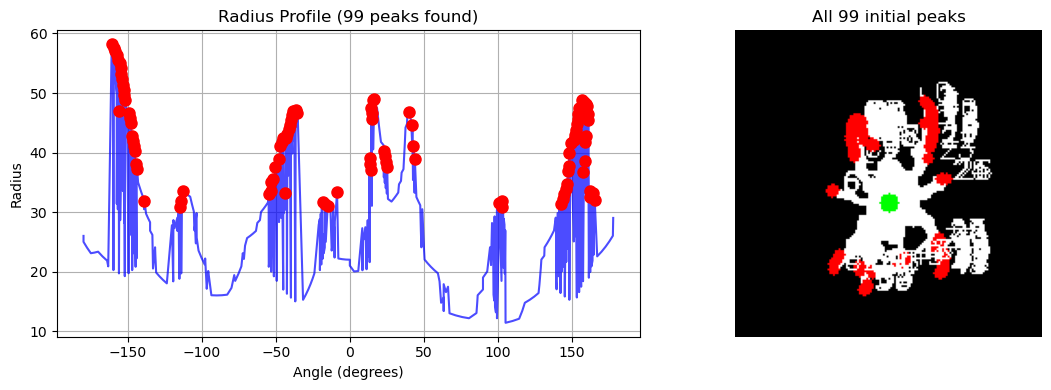

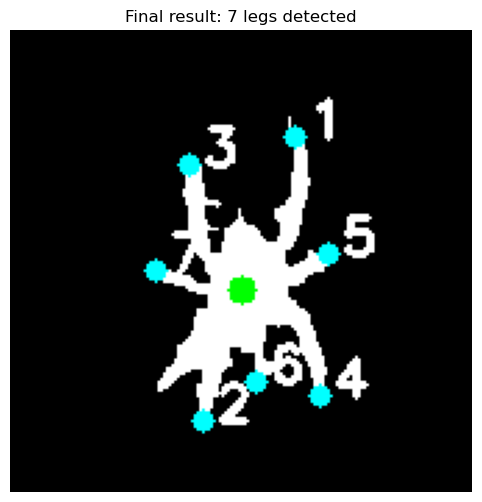

C:\Users\adamain\Downloads\cropped_frames\cropped_29 - 1.jpg


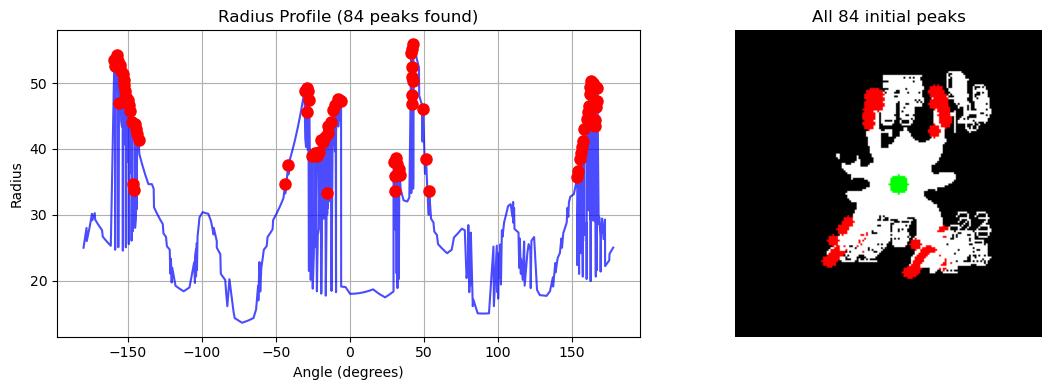

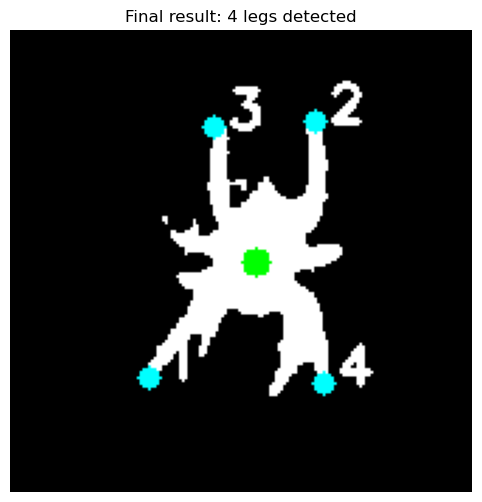

C:\Users\adamain\Downloads\cropped_frames\cropped_40 - 1.jpg


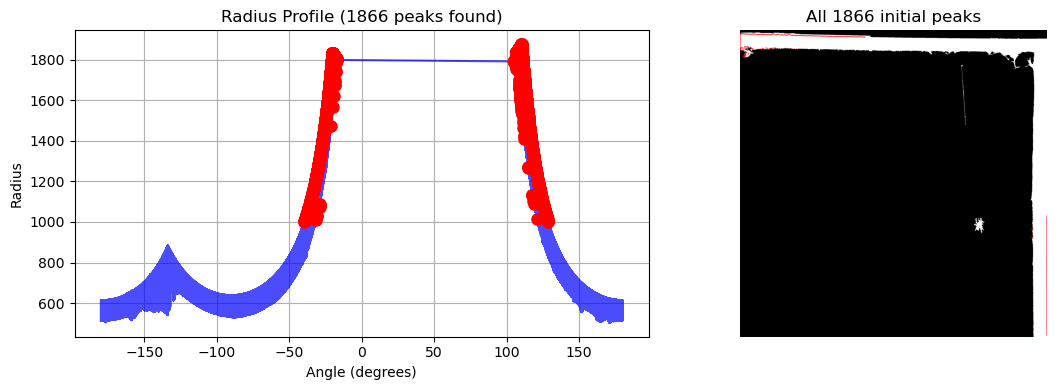

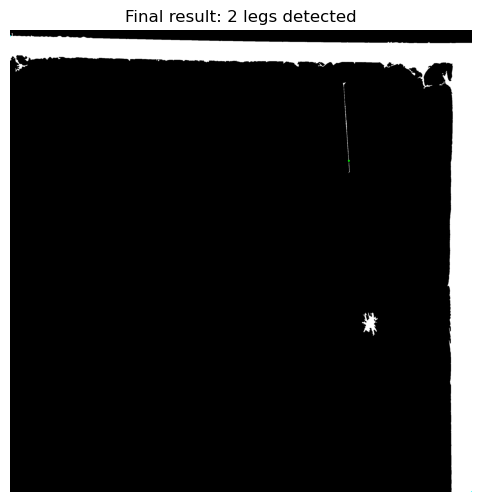

C:\Users\adamain\Downloads\cropped_frames\cropped_41 - 1.jpg


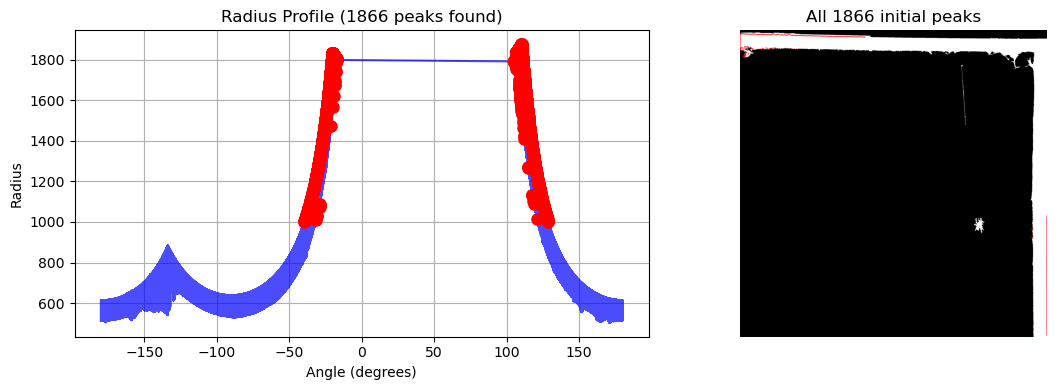

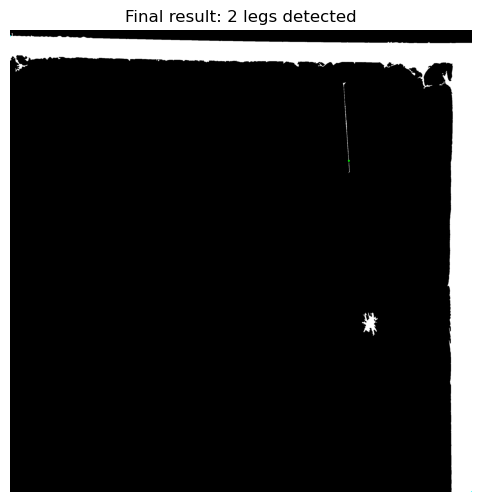

C:\Users\adamain\Downloads\cropped_frames\cropped_41 - 1.jpg


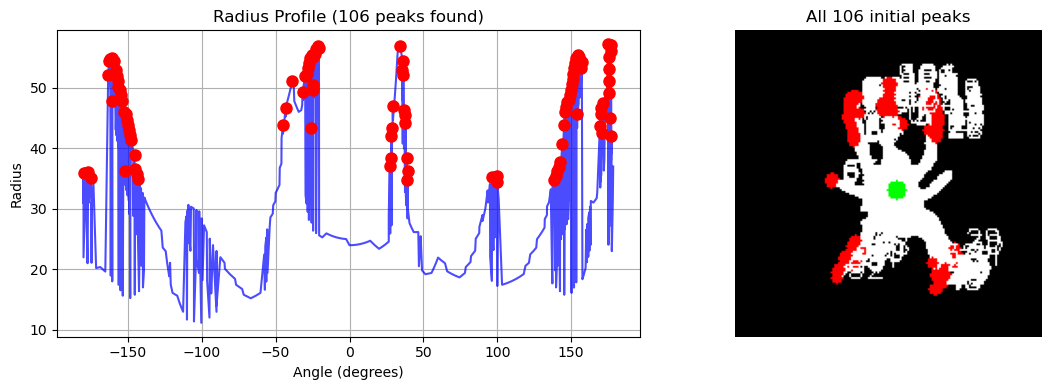

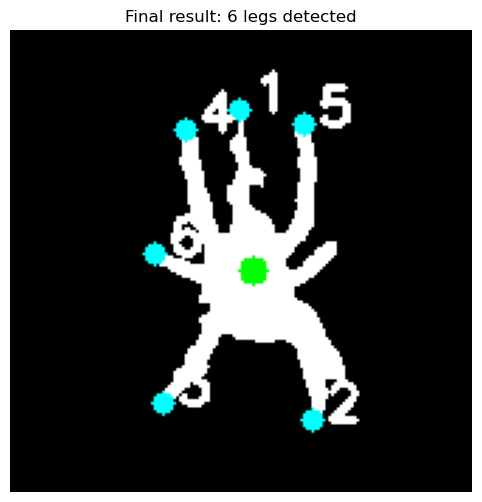

C:\Users\adamain\Downloads\cropped_frames\cropped_41 - 2.jpg


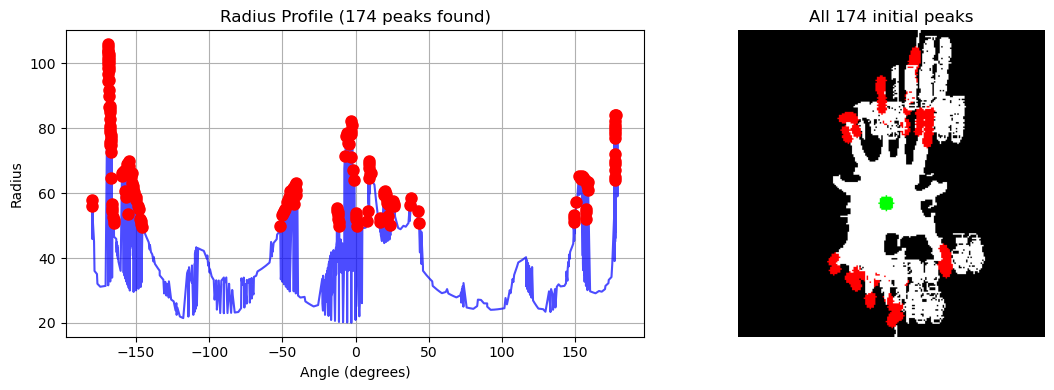

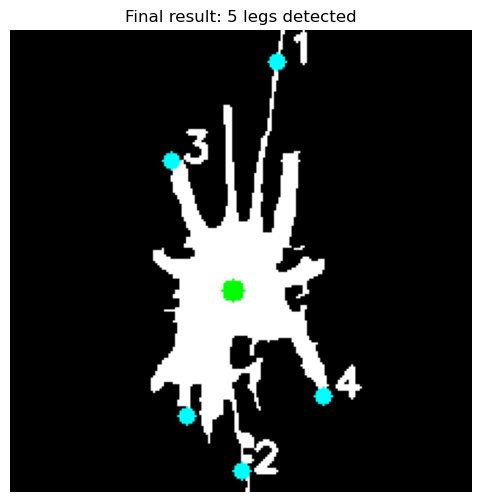

C:\Users\adamain\Downloads\cropped_frames\cropped_42 - 3.jpg


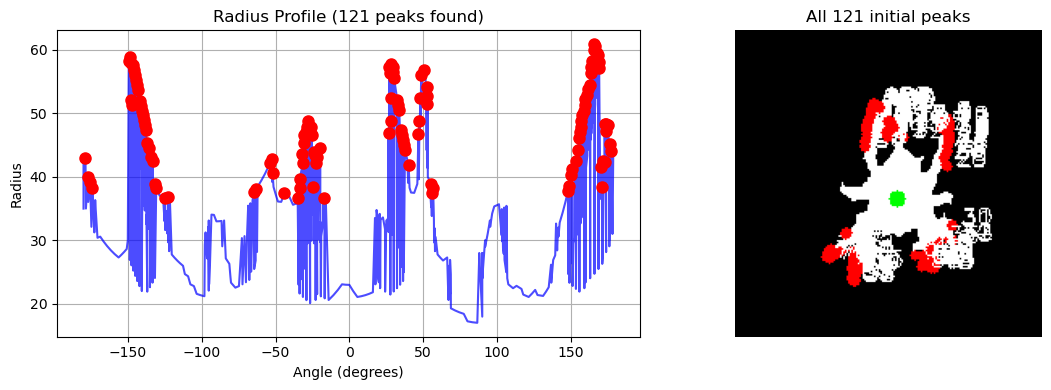

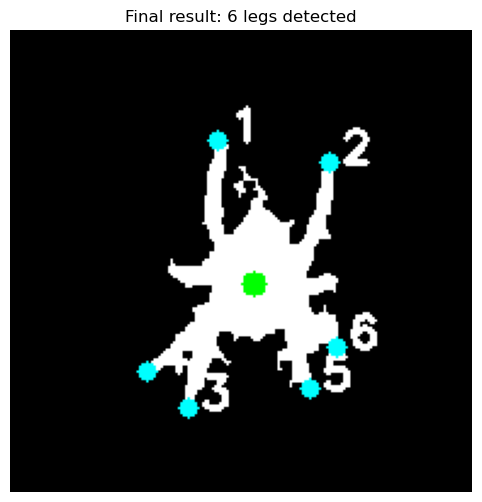

C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 1.jpg


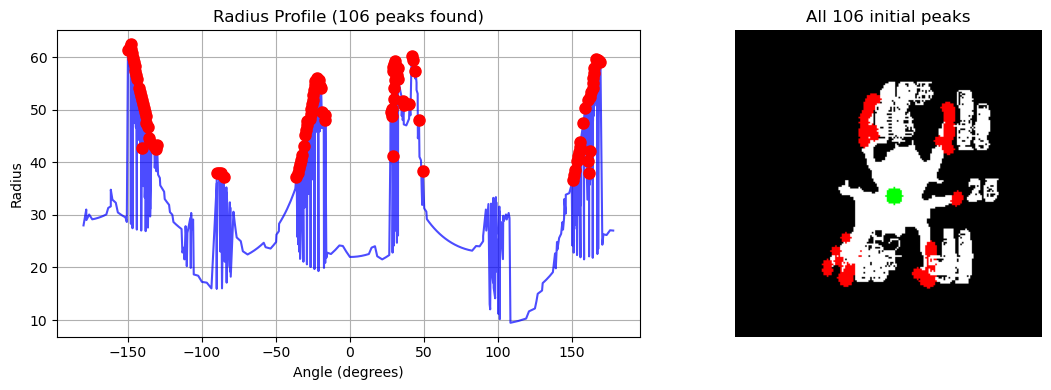

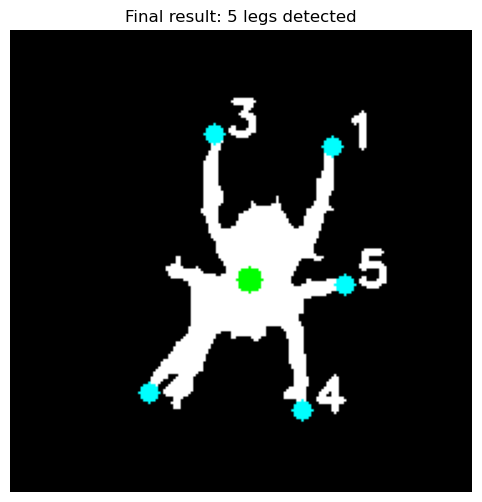

C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 2.jpg


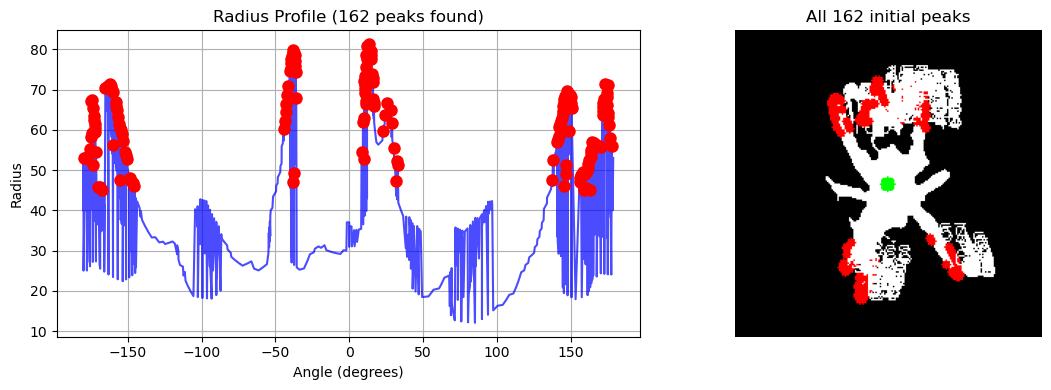

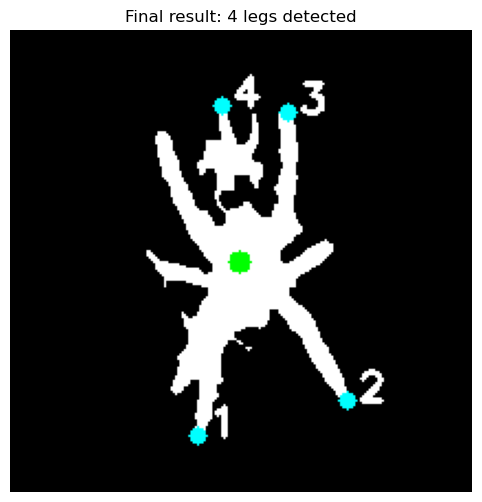

C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 3.jpg


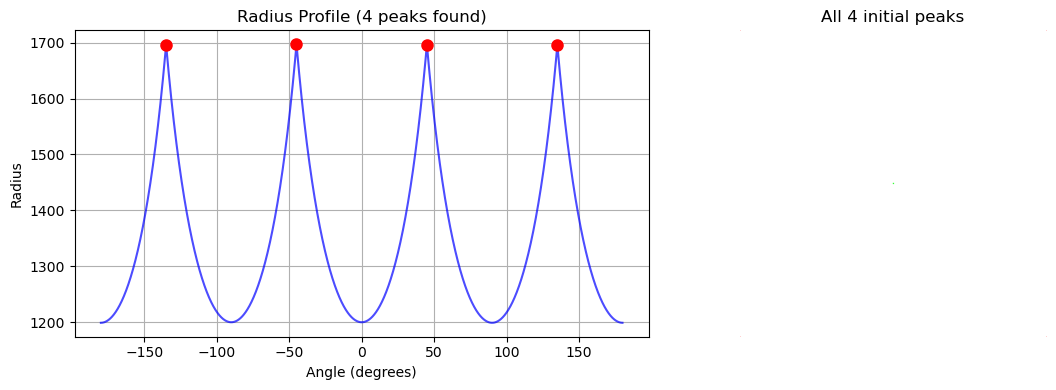

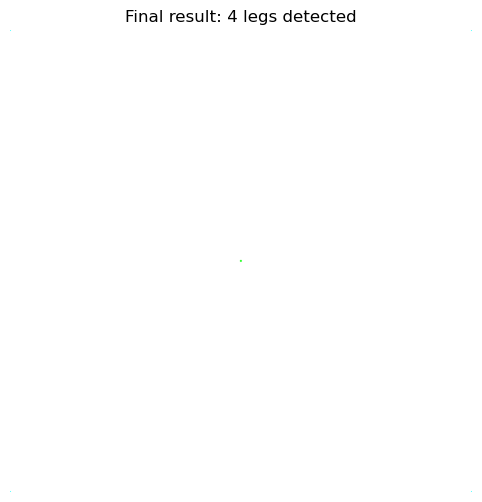

C:\Users\adamain\Downloads\cropped_frames\cropped_58 - 3.jpg


In [ ]:
#Correcting Errors with Trial 3- 29-1, 41-2, 42-3, 43-1, 43-2, 43-3, 58-3
errors = [r"C:\Users\adamain\Downloads\cropped_frames\cropped_29 - 1.jpg", r"C:\Users\adamain\Downloads\cropped_frames\cropped_41 - 1.jpg", r"C:\Users\adamain\Downloads\cropped_frames\cropped_41 - 2.jpg", r"C:\Users\adamain\Downloads\cropped_frames\cropped_42 - 3.jpg", r"C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 1.jpg", r"C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 2.jpg", r"C:\Users\adamain\Downloads\cropped_frames\cropped_43 - 3.jpg", r"C:\Users\adamain\Downloads\cropped_frames\cropped_58 - 3.jpg"]

for image in errors:
    frame = cv2.imread(image)
    thresholded = process_image(frame, aggressive_thresholding = False)
    
    mask, bbox = find_spider_with_dino_and_sam(
        full_image=thresholded,
        reference_mask=reference,
        dino_model=dino_model,
        dino_processor=dino_processor,
        sam_predictor=sam2_predictor
    )
    
    # Get image base name
    base_name = os.path.basename(image)
    name_without_ext = os.path.splitext(base_name)[0]
    
    crop, cropMask = crop_to_mask_circle(thresholded, mask)

    # Save the crop
    crop_path = os.path.join(output_dir, f"{name_without_ext}_crop.png")
    cv2.imwrite(crop_path, crop)

    processed = process_spider(crop)
    leg_numbers.append(count_spider_legs(processed, show_image=True, preprocess = False, output_dir = r"C:\Users\adamain\Downloads\SpiderLegs\Trial 3 - Mean Sorting", base_name = base_name))
    print(image)

In [22]:
#Trial 3- Control Images
import os

# Define the folder path
folder_path = r"C:\Users\adamain\Downloads\cropped_frames"

# Create a list of files that end with " - C.jpg"
control = [
    os.path.join(folder_path, file)
    for file in os.listdir(folder_path)
    if file.endswith(" - C.jpg")
]

# Optional: print the result
print(control)


['C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_19 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_25 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_26 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_29 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_32 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_36 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_39 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_40 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_41 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_42 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_43 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_48 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_49 - C.jpg', 'C:\\Users\\adamain\\Downloads\\cropped_frames\\cropped_50 - C.jpg', 'C:\\Users\\adamain\\Downloads\\c

In [ ]:
#Change this to work with control next time and run it
#Watch out for control boolean in count_spider_legs!
import os
output_dir = r"C:\Users\adamain\Downloads\SpiderCrops\Trial 3 - Mean Sorting"
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

leg_numbers = []
for image in image_paths:
    frame = cv2.imread(image)
    thresholded = process_image(frame)
    
    mask, bbox = find_spider_with_dino_and_sam(
        full_image=thresholded,
        reference_mask=reference,
        dino_model=dino_model,
        dino_processor=dino_processor,
        sam_predictor=sam2_predictor
    )
    
    # Get image base name
    base_name = os.path.basename(image)
    name_without_ext = os.path.splitext(base_name)[0]
    
    crop, cropMask = crop_to_mask_circle(thresholded, mask)

    # Save the crop
    crop_path = os.path.join(output_dir, f"{name_without_ext}_crop.png")
    cv2.imwrite(crop_path, crop)

    processed = process_spider(crop)
    leg_numbers.append(count_spider_legs(processed, show_image=True, preprocess = False, output_dir = r"C:\Users\adamain\Downloads\SpiderLegs\Trial 3 - Mean Sorting", base_name = base_name))